# <font style="color:blue">Train a Custom Object Detector using DarkNet YOLOv3</font>
In this notebook, we will learn how train a object detector for an object of our choice. We will use DarkNet framework and YOLO v3 architecture.

We will use images of Ambulance from Open Images Dataset.

# <font style="color:blue">Change Runtime Type</font>
Before proceeding, make sure that the notebook is running on the GPU. Go to Runtime -> Change runtime type -> Select hardware Accelerator as GPU.

# <font style="color:blue">1. Link Google Drive [ Optional ]</font>
Since it will take considerable amount of time to train the network, it is a good idea to link your Google Drive with Colab so that everything is backed up. So, if the runtime gets disconnected in the middle of something, you can simply re-link the drive and start working. To link drive, just run the cell below and follow the 2 steps.

1. It will generate a link. Click on the link to login to your google account
1. Get the authorization code and paste it in the box under the cell.

You may however choose to do everything without linking google drive and everything will work as usual.

### <font style="color:green">Uncomment the 2 cells below to link google drive</font>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [48]:
# %cd /content/drive/My\ Drive

/content/drive/My Drive


# <font style="color:blue">2. Clone the DarkNet Repository </font>
We will use Alexey's darknet fork which has many modifications and improvements and is actively maintained by him.

In [1]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15379, done.
remote: Total 15379 (delta 0), reused 0 (delta 0), pack-reused 15379
Receiving objects: 100% (15379/15379), 14.01 MiB | 1.14 MiB/s, done.
Resolving deltas: 100% (10341/10341), done.


# <font style="color:blue">3. Compile DarkNet</font>
We will first make some changes to the Makefile before we compile. Specifically, we will enable the following:
1. Build darknet with OpenCV
1. Build with CUDA enabled
1. Build with cuDNN enabled.

In [1]:
%cd darknet

/home/alfonso/Documents/OpenCV_Course/CV II/Project_3/darknet


In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Aug_15_21:14:11_PDT_2021
Cuda compilation tools, release 11.4, V11.4.120
Build cuda_11.4.r11.4/compiler.30300941_0


In [4]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

print("Building. . . It might take 2-3 minutes")

!make &> build_log.txt

Building. . . It might take 2-3 minutes


# <font style="color:blue">4. Download Data from Open Images Dataset</font>
Given below is the script for downloading data from open images dataset.

It downloads 2 files from Open Images. 

1. **train-annotations-bbox.csv** contains the bounding box labels for all images present in the training data of Open Images
1. **class-descriptions-boxable.csv** contains the classes which have bounding box annotations available in the dataset.

Using these 2 files we can get a list of all files corresponding to a particular class.

You can specify which classes you want to download and it will download the data. One thing to note here is that YOLO expects the bounding boxes to be in a specific format as given below.

```
<object-class> <x_center> <y_center> <width> <height>
```

The first field object-class-id is an integer representing the class of the object. It ranges from 0 to (number of classes – 1). In our current case, since we have only one class of snowman, it is always set to 0.

The second and third entry, center-x and center-y are respectively the x and y coordinates of the center of the bounding box, normalized (divided) by the image width and height respectively.

The fourth and fifth entry, width and height are respectively the width and height of the bounding box, again normalized (divided) by the image width and height respectively.

Let’s consider an example with the following notations:
```
x – x-coordinate(in pixels) of the center of the bounding box
y – y-coordinate(in pixels) of the center of the bounding box
w – width(in pixels) of the bounding box
h – height(in pixels) of the bounding box
W – width(in pixels) of the whole image
H – height(in pixels) of the whole image
```
Then we compute the annotation values in the label files as follows:
```
center-x = x / W
center-y = y / H
width = w / W
height = h / H
```
The above four entries are all floating point values between 0 to 1.

Note that the 2nd and 3rd elements are centers and NOT the top/bottom left corners. This is different from most datasets available on the internet. 

Thus, we reformat the bounding boxes according to YOLO in the last line of code in the function below.

**NOTE:** Downloading the data from aws takes considerable amount of time ( ~7 seconds per image ). Thus, we have provided a zip file for the dataset which you can download in the next cell. You can use the script to download other classes when you experiment further.

Uncomment the cell below if you want to download a new class. You can download the data using the cell below.

In [0]:
## It might ask you to restart runtime, but it is not required.
# download_open_images_data(classes, maxImages)

## <font style="color:blue">4.1. Download Data</font>
Download the data which we have shared using the dropbox link. This is a faster way. You can use the above process for downloading any other category.

In [ ]:
#!wget "https://www.dropbox.com/s/84jr6gxlvrw3azy/OID-data.zip?dl=1" -O OID-data.zip
#!unzip -o OID-data.zip &> /dev/null

## <font style="color:blue">4.2. Prepare dataset files</font>
We need to create a txt file which contains the path to the images. These files will be used while setting up the training. 

The data is split into train and test in the ratio of 80:20. So, we will use 80% of the data for training and the rest for testing after a few iterations of training.

In [2]:
%cd ..

/home/alfonso/Documents/OpenCV_Course/CV II/Project_3


In [11]:
import random
import os
import subprocess
import sys

image_dir = "./train_images"
f_val = open("data_val.txt", 'w')
f_train = open("data_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
    if (f.split(".")[-1] == "jpeg" or f.split(".")[-1] == "jpg") :
        ind += 1
        
        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

# <font style="color:blue">5. Download Code for YOLO Training</font>
We have shared the code for training in the link below. Explanation of each file follows next.

You can see there are 4 files which have been downloaded. We will go through each file in the next section.

# <font style="color:blue">6. Download weights for Convolutional backbone</font>
When you train your own object detector, it is a good idea to leverage existing models trained on very large datasets even though the large dataset may not contain the object you are trying to detect. This process is called transfer learning.

Instead of learning from scratch, we use a pre-trained model which contains convolutional weights trained on ImageNet. Using these weights as our starting weights, our network can learn faster. We will use the pre-trained convolutional backbone. 

We will download the weights file from our server as the author's server seemed slow. If you face any issues, you can download the file from the link given in the code below.

In [24]:
# Original File : https://pjreddie.com/media/files/darknet53.conv.74
!wget "https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1" -O darknet53.conv.74

--2021-12-11 16:37:24--  https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/18dwbfth7prbf0h/darknet53.conv.74 [following]
--2021-12-11 16:37:25--  https://www.dropbox.com/s/dl/18dwbfth7prbf0h/darknet53.conv.74
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca1e13750af22e88fa9b682a681.dl.dropboxusercontent.com/cd/0/get/Bbr96ABtVqgzObBDOPbA7D5Q8bNXOvdjNTRHjaGlLiNRQiy4GTpzcGvDC0kb8fS-rWgAlQcdcSGe7Ix9hVbuCh8qQLL85wBV8xwPh65h3x76uDfKtWQgpMcBiJEAG8MgLzFCSGG7cAXWKm4XWshzdV4S/file?dl=1# [following]
--2021-12-11 16:37:25--  https://uca1e13750af22e88fa9b682a681.dl.dropboxusercontent.com/cd/0/get/Bbr96ABtVqgzObBDOPbA7D5Q8bNXOvdjNTRHjaGlLiNRQiy4GTpzcGvDC0kb8fS-rWgAlQcdc

# <font style="color:blue">7. Training Configuration</font>
As explained in the theory section, we will use the config file to specify the various training parameters. A gist of all the parameters is given below:

## <font style="color:blue">7.1. Data Setup</font>
In the file **`yolov3-ambulance-setup.data`**(included in our code), we need to provide information about the specifications for our object detector and some relevant paths.

The contents of the file are as follows:
```
classes = 1
train  = data_train.txt
valid  = data_test.txt
names = class.names
backup = backup/
```
The classes parameter needs the number of classes. In our case, it is 1.

You need to provide the absolute paths of the files **`data_train.txt`** and **`data_test.txt`** generated earlier, which have the list of files to be used for training(train parameter) and validation(valid parameter) respectively.

The names field represents the path of a file which contains the names of all the classes. We have included the **`class.names`** file which contains the class name **`Ambulance`**. You will need to provide its absolute path in your machine here.

Lastly, for the **`backup`** parameter, we need to give the path to an existing directory where we can store the intermediate weights files as the training progresses.

## <font style="color:blue">7.2. Training Config File</font>
Along with the yolov3-ambulance-setup.data and class.names files, YOLOv3 also needs a configuration file **`yolov3-ambulance-train.cfg`**. It is based on the demo configuration file, yolov3-voc.cfg (comes with darknet code), which was used to train on the VOC dataset. All the important training parameters are stored in this configuration file. Let us understand what they mean and what values to set them to.

### <font style="color:green">7.2.1 Batch hyper-parameter in YOLOv3</font>
Let’s learn more about batch and subdivision parameter.
```
[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=64
subdivisions=16
```
The batch parameter indicates the batch size used during training.

Our training set contains a few hundred images, but it is not uncommon to train on million of images. The training process involves iteratively updating the weights of the neural network based on how many mistakes it is making on the training dataset.

It is impractical (and unnecessary) to use all images in the training set at once to update the weights. So, a small subset of images is used in one iteration, and this subset is called the batch size.

When the batch size is set to 64, it means 64 images are used in one iteration to update the parameters of the neural network.

### <font style="color:green">7.2.2 Subdivisions configuration parameter in YOLOv3</font>
Even though you may want to use a batch size of 64 for training your neural network, you may not have a GPU with enough memory to use a batch size of 64. Fortunately, Darknet allows you to specify a variable called subdivisions that lets you process a fraction of the batch size at one time on your GPU.

You can start the training with subdivisions=1, and if you get an Out of memory error, increase the subdivisions parameter by multiples of 2(e.g. 2, 4, 8, 16) till the training proceeds successfully. The GPU will process batch/subdivision number of images at any time, but the full batch or iteration would be complete only after all the 64 (as set above) images are processed.

During testing, both batch and subdivision are set to 1.

### <font style="color:green">7.2.3 Width, Height, Channels</font>
These configuration parameters specify the input image size and the number of channels.

```
width=416
height=416
channels=3
```
The input training images are first resized to width x height before training. Here we use the default values of 416×416. The results might improve if we increase it to 608×608, but it would take longer to train too. channels=3 indicates that we would be processing 3-channel RGB input images.

### <font style="color:green">7.2.4 Momentum and Decay</font>
The configuration file contains a few parameters that control how the weight is updated.
```
momentum=0.9
decay=0.0005
```
In the previous section, we mentioned how the weights of a neural network are updated based on a small batch of images and not the entire dataset. Because of this reason, the weight updates fluctuate quite a bit. That is why a parameter momentum is used to penalize large weight changes between iterations.

A typical neural network has millions of weights and therefore they can easily overfit any training data. Overfitting simply means it will do very well on training data and poorly on test data. It is almost like the neural network has memorized the answer to all images in the training set, but really not learned the underlying concept. One of the ways to mitigate this problem is to penalize large value for weights. The parameter decay controls this penalty term. The default value works just fine, but you may want to tweak this if you notice overfitting.

### <font style="color:green">7.2.5 Learning Rate, Steps, Scales, Burn In (warm-up)</font>
```
learning_rate=0.001
policy=steps
steps=800
scales=.1
burn_in=100
```
The parameter learning rate controls how aggressively we should learn based on the current batch of data. Typically this is a number between 0.01 and 0.0001.

At the beginning of the training process, we are starting with zero information and so the learning rate needs to be high. But as the neural network sees a lot of data, the weights need to change less aggressively. In other words, the learning rate needs to be decreased over time. In the configuration file, this decrease in learning rate is accomplished by first specifying that our learning rate decreasing policy is steps. In the above example, the learning rate will start from 0.001 and remain constant for 800 iterations, and then it will multiply by scales to get the new learning rate. We could have also specified multiple steps and scales.

In the previous paragraph, we mentioned that the learning rate needs to be high in the beginning and low later on. While that statement is largely true, it has been empirically found that the training speed tends to increase if we have a lower learning rate for a short period of time at the very beginning. This is controlled by the burn_in parameter. Sometimes this **`burn-in`** period is also called warm-up period.

### <font style="color:green">7.2.6 Data augmentation</font>
We know data collection takes a long time and it is difficult to find high quality annotated data. We want to make maximum use of this data by cooking up new data. This process is called data augmentation. For example, an image of the ambulance rotated by 5 degrees is still an image of a ambulance. The angle parameter in the configuration file allows you to randomly rotate the given image by ± angle.

Similarly, if we transform the colors of the entire picture using saturation, exposure, and hue, it is still a picture of the ambulance.
```
angle=0
saturation = 1.5
exposure = 1.5
hue=.1
```
We used the default values for training.

### <font style="color:green">7.2.7 Number of iterations</font>
Finally, we need to specify how many iterations should the training process be run for.
```
max_batches=1000
```

For multi-class object detectors, the max_batches number is higher, i.e. we need to run for more number of batches(e.g. in yolov3-voc.cfg). For an n-classes object detector, it is advisable to run the training for at least 2000*n batches. In our case with only 1 class, 1000 seemed like a safe number for max_batches. 

You should try to change the parameter and see how it performs.

### <font style="color:green">7.2.8 Change filters parameter in conv layers [Important for multiple objects]</font>
Change the filters parameter in the convolutional layer just before the yolo layer according to the formula 

**`filters=( classes + 5 ) * 3`**

Since we are using classes = 1, thus, #filters in our case is 18. You should make this change if you are dealing with more classes.


## <font color="blue">7.3. Names file </font>
We need to specify the names of the classes in the **`.names`** file. 

# <font style="color:blue">8. Start Training </font>
For starting training using darknet, we need to execute the following command. Here we are specifying the
1. path to the setup file, 
1. path to config file, 
1. path to convolutional weights file 

and also passing some flags such as:

- **`dont_show`** which wont display the graphs. This is required for Colab since it does not have a display and it will crash if it tries to display, not if you run the notebook on your local system.
- **`map`** - this will calculate mAP - mean average precision for the test data which we have specified using the data_test.txt file which contains 20% of our data.

In [1]:
!./darknet/darknet detector train ./yolov3-mask-setup.data ./yolov3-mask-train.cfg ./darknet53.conv.74 -map 2> train_log.txt

 Prepare additional network for mAP calculation...
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 
yolov3-mask-train
net.optimized_memory = 0 
mini_batch = 4, batch = 64, time_steps = 1, train = 1 

 seen 64, trained: 0 K-images (0 Kilo-batches_64) 
Learning Rate: 0.001, Momentum: 0.9, Decay: 0.0005
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
 If error occurs - run training with flag: -dont_show 
Resizing, random_coef = 1.40 

 608 x 608 
 try to allocate additional workspace_size = 324.11 MB 
 CUDA allocate done! 
Loaded: 0.000043 seconds

 (next mAP calculation at 400 iterations) 
 1: 7019.812012, 7019.812012 avg loss, 0.000000 rate, 5.869254 seconds, 64 images, -1.000000 hours left
Loaded: 0.000103 seconds

 (next mAP calculation at 400 iterations) 
 2: 7020.899902, 7019.920898 avg loss, 0.000000 rate, 5.545782 seconds, 128 images, 8.150178 hour


 (next mAP calculation at 400 iterations) 
 42: 1687.621216, 2057.031006 avg loss, 0.000000 rate, 4.939589 seconds, 2688 images, 6.862324 hours left
Loaded: 0.000063 seconds

 (next mAP calculation at 400 iterations) 
 43: 1403.521118, 1991.680054 avg loss, 0.000000 rate, 5.033597 seconds, 2752 images, 6.861731 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 400 iterations) 
 44: 1148.648438, 1907.376953 avg loss, 0.000000 rate, 5.030653 seconds, 2816 images, 6.862425 hours left
Loaded: 0.000066 seconds

 (next mAP calculation at 400 iterations) 
 45: 929.231995, 1809.562500 avg loss, 0.000000 rate, 4.876027 seconds, 2880 images, 6.863057 hours left
Loaded: 0.000101 seconds

 (next mAP calculation at 400 iterations) 
 46: 748.030762, 1703.409302 avg loss, 0.000000 rate, 4.897260 seconds, 2944 images, 6.861541 hours left
Loaded: 0.000101 seconds

 (next mAP calculation at 400 iterations) 
 47: 608.174561, 1593.885864 avg loss, 0.000000 rate, 4.970932 seconds, 3008 images


 (next mAP calculation at 400 iterations) 
 87: 8.180423, 45.320526 avg loss, 0.000002 rate, 5.022326 seconds, 5568 images, 6.671680 hours left
Loaded: 0.000104 seconds

 (next mAP calculation at 400 iterations) 
 88: 8.148805, 41.603355 avg loss, 0.000002 rate, 4.967034 seconds, 5632 images, 6.673506 hours left
Loaded: 0.000108 seconds

 (next mAP calculation at 400 iterations) 
 89: 6.937615, 38.136780 avg loss, 0.000002 rate, 4.975434 seconds, 5696 images, 6.674545 hours left
Loaded: 0.000092 seconds

 (next mAP calculation at 400 iterations) 
 90: 9.709281, 35.294029 avg loss, 0.000003 rate, 5.032575 seconds, 5760 images, 6.675674 hours left
Resizing, random_coef = 1.40 

 544 x 544 
 try to allocate additional workspace_size = 260.41 MB 
 CUDA allocate done! 
Loaded: 0.000038 seconds

 (next mAP calculation at 400 iterations) 
 91: 7.000048, 32.464630 avg loss, 0.000003 rate, 4.518234 seconds, 5824 images, 6.677557 hours left
Loaded: 0.000109 seconds

 (next mAP calculation at 40

Loaded: 0.000078 seconds

 (next mAP calculation at 400 iterations) 
 132: 9.523157, 7.662111 avg loss, 0.000012 rate, 3.668687 seconds, 8448 images, 5.736519 hours left
Loaded: 0.000059 seconds

 (next mAP calculation at 400 iterations) 
 133: 5.336906, 7.429590 avg loss, 0.000012 rate, 3.497119 seconds, 8512 images, 5.728763 hours left
Loaded: 0.000086 seconds

 (next mAP calculation at 400 iterations) 
 134: 6.197446, 7.306376 avg loss, 0.000013 rate, 3.522289 seconds, 8576 images, 5.718756 hours left
Loaded: 0.000068 seconds

 (next mAP calculation at 400 iterations) 
 135: 5.306528, 7.106391 avg loss, 0.000013 rate, 3.517634 seconds, 8640 images, 5.709179 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 400 iterations) 
 136: 7.191337, 7.114885 avg loss, 0.000013 rate, 3.554172 seconds, 8704 images, 5.699625 hours left
Loaded: 0.000112 seconds

 (next mAP calculation at 400 iterations) 
 137: 5.250781, 6.928475 avg loss, 0.000014 rate, 3.497095 seconds, 8768 images, 

Loaded: 0.000089 seconds

 (next mAP calculation at 400 iterations) 
 178: 6.080872, 5.606766 avg loss, 0.000039 rate, 3.687090 seconds, 11392 images, 5.475147 hours left
Loaded: 0.000121 seconds

 (next mAP calculation at 400 iterations) 
 179: 5.423342, 5.588424 avg loss, 0.000040 rate, 3.577351 seconds, 11456 images, 5.469783 hours left
Loaded: 0.000114 seconds

 (next mAP calculation at 400 iterations) 
 180: 5.630402, 5.592622 avg loss, 0.000041 rate, 3.529255 seconds, 11520 images, 5.462994 hours left
Resizing, random_coef = 1.40 

 544 x 544 
 try to allocate additional workspace_size = 260.41 MB 
 CUDA allocate done! 
Loaded: 0.000039 seconds

 (next mAP calculation at 400 iterations) 
 181: 4.534537, 5.486814 avg loss, 0.000042 rate, 4.608814 seconds, 11584 images, 5.455618 hours left
Loaded: 0.000104 seconds

 (next mAP calculation at 400 iterations) 
 182: 5.006046, 5.438737 avg loss, 0.000043 rate, 4.553883 seconds, 11648 images, 5.462757 hours left
Loaded: 0.000092 seconds


 (next mAP calculation at 400 iterations) 
 222: 4.678552, 4.660574 avg loss, 0.000095 rate, 4.572284 seconds, 14208 images, 5.173756 hours left
Loaded: 0.000064 seconds

 (next mAP calculation at 400 iterations) 
 223: 4.240641, 4.618581 avg loss, 0.000097 rate, 4.546810 seconds, 14272 images, 5.182704 hours left
Loaded: 0.000098 seconds

 (next mAP calculation at 400 iterations) 
 224: 5.672939, 4.724017 avg loss, 0.000098 rate, 4.677144 seconds, 14336 images, 5.191212 hours left
Loaded: 0.000065 seconds

 (next mAP calculation at 400 iterations) 
 225: 3.140097, 4.565625 avg loss, 0.000100 rate, 4.497351 seconds, 14400 images, 5.201351 hours left
Loaded: 0.000102 seconds

 (next mAP calculation at 400 iterations) 
 226: 4.094884, 4.518551 avg loss, 0.000102 rate, 4.610030 seconds, 14464 images, 5.208991 hours left
Loaded: 0.000106 seconds

 (next mAP calculation at 400 iterations) 
 227: 4.714712, 4.538167 avg loss, 0.000104 rate, 4.601012 seconds, 14528 images, 5.218036 hours left

Loaded: 0.000086 seconds

 (next mAP calculation at 400 iterations) 
 268: 2.917910, 4.328887 avg loss, 0.000202 rate, 2.702511 seconds, 17152 images, 4.941310 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 400 iterations) 
 269: 3.513316, 4.247330 avg loss, 0.000205 rate, 2.748668 seconds, 17216 images, 4.927421 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 400 iterations) 
 270: 3.879115, 4.210508 avg loss, 0.000208 rate, 2.762573 seconds, 17280 images, 4.914270 hours left
Resizing, random_coef = 1.40 

 352 x 352 
 try to allocate additional workspace_size = 111.77 MB 
 CUDA allocate done! 
Loaded: 0.000046 seconds

 (next mAP calculation at 400 iterations) 
 271: 4.597576, 4.249215 avg loss, 0.000211 rate, 2.049601 seconds, 17344 images, 4.901425 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 400 iterations) 
 272: 4.275677, 4.251861 avg loss, 0.000214 rate, 2.068474 seconds, 17408 images, 4.879335 hours left
Loaded: 0.000074 seconds


 (next mAP calculation at 400 iterations) 
 312: 2.557821, 3.871368 avg loss, 0.000370 rate, 2.306489 seconds, 19968 images, 4.388185 hours left
Loaded: 0.000111 seconds

 (next mAP calculation at 400 iterations) 
 313: 2.475766, 3.731808 avg loss, 0.000375 rate, 2.345564 seconds, 20032 images, 4.374340 hours left
Loaded: 0.000091 seconds

 (next mAP calculation at 400 iterations) 
 314: 3.736014, 3.732229 avg loss, 0.000380 rate, 2.380776 seconds, 20096 images, 4.361136 hours left
Loaded: 0.000120 seconds

 (next mAP calculation at 400 iterations) 
 315: 3.405444, 3.699550 avg loss, 0.000385 rate, 2.374772 seconds, 20160 images, 4.348516 hours left
Loaded: 0.000089 seconds

 (next mAP calculation at 400 iterations) 
 316: 3.196703, 3.649266 avg loss, 0.000390 rate, 2.350085 seconds, 20224 images, 4.335937 hours left
Loaded: 0.000100 seconds

 (next mAP calculation at 400 iterations) 
 317: 2.723763, 3.556715 avg loss, 0.000394 rate, 2.349290 seconds, 20288 images, 4.323156 hours left


 (next mAP calculation at 400 iterations) 
 358: 4.057847, 3.121715 avg loss, 0.000642 rate, 3.602296 seconds, 22912 images, 4.692946 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 400 iterations) 
 359: 2.865350, 3.096078 avg loss, 0.000649 rate, 3.559757 seconds, 22976 images, 4.692467 hours left
Loaded: 0.000064 seconds

 (next mAP calculation at 400 iterations) 
 360: 3.669501, 3.153421 avg loss, 0.000656 rate, 3.550505 seconds, 23040 images, 4.691434 hours left
Resizing, random_coef = 1.40 

 384 x 384 
 try to allocate additional workspace_size = 132.12 MB 
 CUDA allocate done! 
Loaded: 0.165613 seconds - performance bottleneck on CPU or Disk HDD/SSD

 (next mAP calculation at 400 iterations) 
 361: 2.489566, 3.087035 avg loss, 0.000663 rate, 2.284713 seconds, 23104 images, 4.690283 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 400 iterations) 
 362: 2.943503, 3.072682 avg loss, 0.000671 rate, 2.344716 seconds, 23168 images, 4.674955 hours left
L

Resizing, random_coef = 1.40 

 512 x 512 
 try to allocate additional workspace_size = 231.21 MB 
 CUDA allocate done! 
Loaded: 0.000036 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.50 = 63.23 %, best = 63.23 % 
 401: 4.075205, 2.785773 avg loss, 0.001000 rate, 3.877322 seconds, 25664 images, 4.459482 hours left
Loaded: 0.000064 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.50 = 63.23 %, best = 63.23 % 
 402: 1.834466, 2.690642 avg loss, 0.001000 rate, 3.749182 seconds, 25728 images, 4.464420 hours left
Loaded: 0.000055 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.50 = 63.23 %, best = 63.23 % 
 403: 2.543421, 2.675920 avg loss, 0.001000 rate, 3.818476 seconds, 25792 images, 4.467662 hours left
Loaded: 0.000090 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.50 = 63.23 %, best = 63.23 % 
 404: 2.205912, 2.628919 avg loss, 0.001000 rate, 3.759045 seconds, 25856 images, 4.471746 ho

Loaded: 0.000108 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.50 = 63.23 %, best = 63.23 % 
 436: 2.254869, 2.405276 avg loss, 0.001000 rate, 2.371400 seconds, 27904 images, 4.318104 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.50 = 63.23 %, best = 63.23 % 
 437: 1.985279, 2.363276 avg loss, 0.001000 rate, 2.344175 seconds, 27968 images, 4.304989 hours left
Loaded: 0.000091 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.50 = 63.23 %, best = 63.23 % 
 438: 1.711547, 2.298104 avg loss, 0.001000 rate, 2.321007 seconds, 28032 images, 4.291652 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.50 = 63.23 %, best = 63.23 % 
 439: 2.566234, 2.324917 avg loss, 0.001000 rate, 2.369305 seconds, 28096 images, 4.278149 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.50 = 63.23 %, best = 6


 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.50 = 63.23 %, best = 63.23 % 
 471: 2.035342, 2.044239 avg loss, 0.001000 rate, 2.294019 seconds, 30144 images, 4.346723 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.50 = 63.23 %, best = 63.23 % 
 472: 3.489363, 2.188751 avg loss, 0.001000 rate, 2.365582 seconds, 30208 images, 4.332116 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.50 = 63.23 %, best = 63.23 % 
 473: 1.892116, 2.159088 avg loss, 0.001000 rate, 2.334648 seconds, 30272 images, 4.318550 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.50 = 63.23 %, best = 63.23 % 
 474: 1.332918, 2.076471 avg loss, 0.001000 rate, 2.288468 seconds, 30336 images, 4.304724 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 500 iterations) 
 Last accuracy mAP@0.50 = 63.23 %, best = 63.23 % 
 475: 3.721200, 2

Loaded: 0.000075 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.50 = 73.34 %, best = 73.34 % 
 502: 2.898330, 2.033124 avg loss, 0.001000 rate, 2.077314 seconds, 32128 images, 4.172879 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.50 = 73.34 %, best = 73.34 % 
 503: 4.541484, 2.283960 avg loss, 0.001000 rate, 2.162985 seconds, 32192 images, 4.157106 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.50 = 73.34 %, best = 73.34 % 
 504: 2.999657, 2.355530 avg loss, 0.001000 rate, 2.087670 seconds, 32256 images, 4.142556 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.50 = 73.34 %, best = 73.34 % 
 505: 2.837602, 2.403737 avg loss, 0.001000 rate, 2.086650 seconds, 32320 images, 4.127204 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.50 = 73.34 %, best = 7


 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.50 = 73.34 %, best = 73.34 % 
 538: 1.872889, 2.226438 avg loss, 0.001000 rate, 4.601922 seconds, 34432 images, 4.274765 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.50 = 73.34 %, best = 73.34 % 
 539: 2.281062, 2.231900 avg loss, 0.001000 rate, 4.623463 seconds, 34496 images, 4.289056 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.50 = 73.34 %, best = 73.34 % 
 540: 1.176451, 2.126355 avg loss, 0.001000 rate, 4.511787 seconds, 34560 images, 4.303459 hours left
Resizing, random_coef = 1.40 

 352 x 352 
 try to allocate additional workspace_size = 111.77 MB 
 CUDA allocate done! 
Loaded: 0.000057 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.50 = 73.34 %, best = 73.34 % 
 541: 2.553967, 2.169116 avg loss, 0.001000 rate, 2.072019 seconds, 34624 images, 4.316322 hours left
Loaded: 0.000065


 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.50 = 73.34 %, best = 73.34 % 
 573: 1.486660, 1.881449 avg loss, 0.001000 rate, 2.039016 seconds, 36672 images, 4.211740 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.50 = 73.34 %, best = 73.34 % 
 574: 2.285810, 1.921885 avg loss, 0.001000 rate, 2.066813 seconds, 36736 images, 4.194697 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.50 = 73.34 %, best = 73.34 % 
 575: 2.043830, 1.934079 avg loss, 0.001000 rate, 2.052986 seconds, 36800 images, 4.178162 hours left
Loaded: 0.000086 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.50 = 73.34 %, best = 73.34 % 
 576: 2.014489, 1.942120 avg loss, 0.001000 rate, 2.044879 seconds, 36864 images, 4.161616 hours left
Loaded: 0.000087 seconds

 (next mAP calculation at 600 iterations) 
 Last accuracy mAP@0.50 = 73.34 %, best = 73.34 % 
 577: 1.989250, 1


 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.50 = 75.11 %, best = 75.11 % 
 604: 1.217412, 1.891255 avg loss, 0.001000 rate, 4.537925 seconds, 38656 images, 3.961171 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.50 = 75.11 %, best = 75.11 % 
 605: 1.469775, 1.849107 avg loss, 0.001000 rate, 4.579245 seconds, 38720 images, 3.976974 hours left
Loaded: 0.000082 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.50 = 75.11 %, best = 75.11 % 
 606: 2.484985, 1.912695 avg loss, 0.001000 rate, 4.660982 seconds, 38784 images, 3.993110 hours left
Loaded: 0.000089 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.50 = 75.11 %, best = 75.11 % 
 607: 1.399627, 1.861388 avg loss, 0.001000 rate, 4.534400 seconds, 38848 images, 4.010070 hours left
Loaded: 0.000056 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.50 = 75.11 %, best = 75.11 % 
 608: 2.701881, 1


 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.50 = 75.11 %, best = 75.11 % 
 640: 1.549771, 1.717459 avg loss, 0.001000 rate, 2.728869 seconds, 40960 images, 4.177236 hours left
Resizing, random_coef = 1.40 

 512 x 512 
 try to allocate additional workspace_size = 231.21 MB 
 CUDA allocate done! 
Loaded: 0.000039 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.50 = 75.11 %, best = 75.11 % 
 641: 1.868163, 1.732529 avg loss, 0.001000 rate, 3.733448 seconds, 41024 images, 4.168514 hours left
Loaded: 0.000086 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.50 = 75.11 %, best = 75.11 % 
 642: 1.471513, 1.706427 avg loss, 0.001000 rate, 3.787123 seconds, 41088 images, 4.172035 hours left
Loaded: 0.000088 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.50 = 75.11 %, best = 75.11 % 
 643: 2.279846, 1.763769 avg loss, 0.001000 rate, 3.814255 seconds, 41152 images, 4.176161 hours left
Loaded: 0.000081


 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.50 = 75.11 %, best = 75.11 % 
 675: 1.355208, 1.744567 avg loss, 0.001000 rate, 2.723625 seconds, 43200 images, 3.937974 hours left
Loaded: 0.000095 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.50 = 75.11 %, best = 75.11 % 
 676: 1.019155, 1.672026 avg loss, 0.001000 rate, 2.682321 seconds, 43264 images, 3.931317 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.50 = 75.11 %, best = 75.11 % 
 677: 1.381729, 1.642996 avg loss, 0.001000 rate, 2.736382 seconds, 43328 images, 3.924223 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.50 = 75.11 %, best = 75.11 % 
 678: 1.168440, 1.595540 avg loss, 0.001000 rate, 2.703239 seconds, 43392 images, 3.917841 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 700 iterations) 
 Last accuracy mAP@0.50 = 75.11 %, best = 75.11 % 
 679: 1.094213, 1


 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.50 = 81.06 %, best = 81.06 % 
 706: 1.436212, 1.651359 avg loss, 0.001000 rate, 2.372309 seconds, 45184 images, 3.637106 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.50 = 81.06 %, best = 81.06 % 
 707: 2.123921, 1.698615 avg loss, 0.001000 rate, 2.376986 seconds, 45248 images, 3.629033 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.50 = 81.06 %, best = 81.06 % 
 708: 1.316506, 1.660405 avg loss, 0.001000 rate, 2.304300 seconds, 45312 images, 3.621089 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.50 = 81.06 %, best = 81.06 % 
 709: 2.265235, 1.720888 avg loss, 0.001000 rate, 2.406469 seconds, 45376 images, 3.612351 hours left
Loaded: 0.000088 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.50 = 81.06 %, best = 81.06 % 
 710: 0.930661, 1


 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.50 = 81.06 %, best = 81.06 % 
 741: 2.024205, 1.522878 avg loss, 0.001000 rate, 3.730667 seconds, 47424 images, 3.680386 hours left
Loaded: 0.000083 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.50 = 81.06 %, best = 81.06 % 
 742: 1.238526, 1.494443 avg loss, 0.001000 rate, 3.763043 seconds, 47488 images, 3.687718 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.50 = 81.06 %, best = 81.06 % 
 743: 1.074317, 1.452430 avg loss, 0.001000 rate, 3.761024 seconds, 47552 images, 3.695351 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.50 = 81.06 %, best = 81.06 % 
 744: 3.436010, 1.650788 avg loss, 0.001000 rate, 4.049590 seconds, 47616 images, 3.702872 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.50 = 81.06 %, best = 81.06 % 
 745: 0.920678, 1

Loaded: 0.000064 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.50 = 81.06 %, best = 81.06 % 
 777: 1.572680, 1.535786 avg loss, 0.001000 rate, 4.593511 seconds, 49728 images, 3.843806 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.50 = 81.06 %, best = 81.06 % 
 778: 1.150015, 1.497209 avg loss, 0.001000 rate, 4.585323 seconds, 49792 images, 3.859253 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.50 = 81.06 %, best = 81.06 % 
 779: 0.958582, 1.443346 avg loss, 0.001000 rate, 4.501724 seconds, 49856 images, 3.874437 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 800 iterations) 
 Last accuracy mAP@0.50 = 81.06 %, best = 81.06 % 
 780: 1.209439, 1.419955 avg loss, 0.001000 rate, 4.563508 seconds, 49920 images, 3.888477 hours left
Resizing, random_coef = 1.40 

 608 x 608 
 try to allocate additional workspace_size = 324.11 MB 
 CUDA allocat

Loaded: 0.000072 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.50 = 79.79 %, best = 81.06 % 
 808: 1.107240, 1.450647 avg loss, 0.001000 rate, 2.723808 seconds, 51712 images, 4.046092 hours left
Loaded: 0.000086 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.50 = 79.79 %, best = 81.06 % 
 809: 1.515756, 1.457158 avg loss, 0.001000 rate, 2.724778 seconds, 51776 images, 4.037349 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.50 = 79.79 %, best = 81.06 % 
 810: 1.124916, 1.423934 avg loss, 0.001000 rate, 2.709472 seconds, 51840 images, 4.028698 hours left
Resizing, random_coef = 1.40 

 416 x 416 
 try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 
Loaded: 0.000043 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.50 = 79.79 %, best = 81.06 % 
 811: 2.231049, 1.504645 avg loss, 0.001000 rate, 2.727534 seconds, 51904 images, 4.019947 ho

Loaded: 0.000065 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.50 = 79.79 %, best = 81.06 % 
 843: 1.203451, 1.620158 avg loss, 0.001000 rate, 3.481829 seconds, 53952 images, 4.239074 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.50 = 79.79 %, best = 81.06 % 
 844: 1.815487, 1.639691 avg loss, 0.001000 rate, 3.538767 seconds, 54016 images, 4.236890 hours left
Loaded: 0.000087 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.50 = 79.79 %, best = 81.06 % 
 845: 1.157583, 1.591480 avg loss, 0.001000 rate, 3.504079 seconds, 54080 images, 4.235375 hours left
Loaded: 0.000082 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.50 = 79.79 %, best = 81.06 % 
 846: 1.261289, 1.558461 avg loss, 0.001000 rate, 3.493811 seconds, 54144 images, 4.233465 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.50 = 79.79 %, best = 8

Loaded: 0.000073 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.50 = 79.79 %, best = 81.06 % 
 879: 1.717650, 1.558049 avg loss, 0.001000 rate, 5.584034 seconds, 56256 images, 4.248456 hours left
Loaded: 0.000068 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.50 = 79.79 %, best = 81.06 % 
 880: 1.184318, 1.520676 avg loss, 0.001000 rate, 5.462966 seconds, 56320 images, 4.269894 hours left
Resizing, random_coef = 1.40 

 544 x 544 
 try to allocate additional workspace_size = 260.41 MB 
 CUDA allocate done! 
Loaded: 0.041725 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.50 = 79.79 %, best = 81.06 % 
 881: 1.029705, 1.471579 avg loss, 0.001000 rate, 4.454573 seconds, 56384 images, 4.289717 hours left
Loaded: 0.000084 seconds

 (next mAP calculation at 900 iterations) 
 Last accuracy mAP@0.50 = 79.79 %, best = 81.06 % 
 882: 1.244238, 1.448845 avg loss, 0.001000 rate, 4.577401 seconds, 56448 images, 4.298265 ho

Loaded: 0.000070 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.50 = 77.35 %, best = 81.06 % 
 910: 1.315846, 1.529362 avg loss, 0.001000 rate, 2.066557 seconds, 58240 images, 4.334500 hours left
Resizing, random_coef = 1.40 

 352 x 352 
 try to allocate additional workspace_size = 111.77 MB 
 CUDA allocate done! 
Loaded: 0.000037 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.50 = 77.35 %, best = 81.06 % 
 911: 2.827018, 1.659128 avg loss, 0.001000 rate, 2.111389 seconds, 58304 images, 4.314634 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.50 = 77.35 %, best = 81.06 % 
 912: 0.725940, 1.565809 avg loss, 0.001000 rate, 2.006866 seconds, 58368 images, 4.295470 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.50 = 77.35 %, best = 81.06 % 
 913: 1.492408, 1.558469 avg loss, 0.001000 rate, 2.063668 seconds, 58432 images, 4.27530


 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.50 = 77.35 %, best = 81.06 % 
 945: 1.138119, 1.749513 avg loss, 0.001000 rate, 2.711259 seconds, 60480 images, 4.120579 hours left
Loaded: 0.000093 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.50 = 77.35 %, best = 81.06 % 
 946: 1.111138, 1.685675 avg loss, 0.001000 rate, 2.694957 seconds, 60544 images, 4.109913 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.50 = 77.35 %, best = 81.06 % 
 947: 1.099304, 1.627038 avg loss, 0.001000 rate, 2.703367 seconds, 60608 images, 4.099163 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.50 = 77.35 %, best = 81.06 % 
 948: 1.404127, 1.604747 avg loss, 0.001000 rate, 2.722287 seconds, 60672 images, 4.088608 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.50 = 77.35 %, best = 81.06 % 
 949: 1.0964

Resizing, random_coef = 1.40 

 352 x 352 
 try to allocate additional workspace_size = 111.77 MB 
 CUDA allocate done! 
Loaded: 0.000036 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.50 = 77.35 %, best = 81.06 % 
 981: 1.174733, 1.318812 avg loss, 0.001000 rate, 1.987408 seconds, 62784 images, 3.766820 hours left
Loaded: 0.000089 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.50 = 77.35 %, best = 81.06 % 
 982: 2.556311, 1.442562 avg loss, 0.001000 rate, 2.119647 seconds, 62848 images, 3.751340 hours left
Loaded: 0.000087 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.50 = 77.35 %, best = 81.06 % 
 983: 1.196345, 1.417940 avg loss, 0.001000 rate, 2.052150 seconds, 62912 images, 3.737485 hours left
Loaded: 0.000091 seconds

 (next mAP calculation at 1000 iterations) 
 Last accuracy mAP@0.50 = 77.35 %, best = 81.06 % 
 984: 2.225141, 1.498660 avg loss, 0.001000 rate, 2.099377 seconds, 62976 images, 3.72301


 (next mAP calculation at 1100 iterations) 
 Last accuracy mAP@0.50 = 83.51 %, best = 83.51 % 
 1011: 1.114105, 1.448690 avg loss, 0.001000 rate, 2.658729 seconds, 64704 images, 3.472365 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 1100 iterations) 
 Last accuracy mAP@0.50 = 83.51 %, best = 83.51 % 
 1012: 2.203661, 1.524187 avg loss, 0.001000 rate, 2.832481 seconds, 64768 images, 3.467102 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 1100 iterations) 
 Last accuracy mAP@0.50 = 83.51 %, best = 83.51 % 
 1013: 2.055686, 1.577337 avg loss, 0.001000 rate, 2.808391 seconds, 64832 images, 3.463809 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 1100 iterations) 
 Last accuracy mAP@0.50 = 83.51 %, best = 83.51 % 
 1014: 0.949979, 1.514601 avg loss, 0.001000 rate, 2.681239 seconds, 64896 images, 3.460275 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 1100 iterations) 
 Last accuracy mAP@0.50 = 83.51 %, best = 83.51 % 
 1015: 2


 (next mAP calculation at 1100 iterations) 
 Last accuracy mAP@0.50 = 83.51 %, best = 83.51 % 
 1046: 1.262670, 1.285166 avg loss, 0.001000 rate, 3.542551 seconds, 66944 images, 3.413850 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 1100 iterations) 
 Last accuracy mAP@0.50 = 83.51 %, best = 83.51 % 
 1047: 2.192215, 1.375871 avg loss, 0.001000 rate, 3.652315 seconds, 67008 images, 3.418621 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 1100 iterations) 
 Last accuracy mAP@0.50 = 83.51 %, best = 83.51 % 
 1048: 0.814362, 1.319720 avg loss, 0.001000 rate, 3.437542 seconds, 67072 images, 3.424540 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 1100 iterations) 
 Last accuracy mAP@0.50 = 83.51 %, best = 83.51 % 
 1049: 2.011198, 1.388868 avg loss, 0.001000 rate, 3.685462 seconds, 67136 images, 3.428032 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 1100 iterations) 
 Last accuracy mAP@0.50 = 83.51 %, best = 83.51 % 
 1050: 1

 try to allocate additional workspace_size = 93.19 MB 
 CUDA allocate done! 
Loaded: 0.082749 seconds

 (next mAP calculation at 1100 iterations) 
 Last accuracy mAP@0.50 = 83.51 %, best = 83.51 % 
 1081: 1.171005, 1.343851 avg loss, 0.001000 rate, 1.749400 seconds, 69184 images, 3.456488 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 1100 iterations) 
 Last accuracy mAP@0.50 = 83.51 %, best = 83.51 % 
 1082: 2.103405, 1.419807 avg loss, 0.001000 rate, 1.817180 seconds, 69248 images, 3.441868 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 1100 iterations) 
 Last accuracy mAP@0.50 = 83.51 %, best = 83.51 % 
 1083: 1.764553, 1.454281 avg loss, 0.001000 rate, 1.803962 seconds, 69312 images, 3.427228 hours left
Loaded: 0.000065 seconds

 (next mAP calculation at 1100 iterations) 
 Last accuracy mAP@0.50 = 83.51 %, best = 83.51 % 
 1084: 1.795325, 1.488386 avg loss, 0.001000 rate, 1.823135 seconds, 69376 images, 3.412584 hours left
Loaded: 0.000072 seconds

 


 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1112: 0.926125, 1.225166 avg loss, 0.001000 rate, 5.428765 seconds, 71168 images, 3.402375 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1113: 0.892088, 1.191858 avg loss, 0.001000 rate, 5.513848 seconds, 71232 images, 3.426983 hours left
Loaded: 0.000062 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1114: 0.835835, 1.156256 avg loss, 0.001000 rate, 5.445685 seconds, 71296 images, 3.452249 hours left
Loaded: 0.000083 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1115: 0.976222, 1.138253 avg loss, 0.001000 rate, 5.395718 seconds, 71360 images, 3.476510 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1116: 1


 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1147: 0.980376, 1.510347 avg loss, 0.001000 rate, 2.033964 seconds, 73408 images, 3.479151 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1148: 1.606318, 1.519944 avg loss, 0.001000 rate, 2.090831 seconds, 73472 images, 3.466130 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1149: 1.433477, 1.511297 avg loss, 0.001000 rate, 2.066117 seconds, 73536 images, 3.453841 hours left
Loaded: 0.000092 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1150: 1.022899, 1.462458 avg loss, 0.001000 rate, 2.025602 seconds, 73600 images, 3.441405 hours left
Resizing, random_coef = 1.40 

 544 x 544 
 try to allocate additional workspace_size = 260.41 MB 
 CUDA allocate done! 
Loaded: 

Loaded: 0.000086 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1182: 1.119321, 1.439293 avg loss, 0.001000 rate, 4.560264 seconds, 75648 images, 3.427437 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1183: 2.255181, 1.520882 avg loss, 0.001000 rate, 4.769466 seconds, 75712 images, 3.441528 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1184: 1.088225, 1.477616 avg loss, 0.001000 rate, 4.576762 seconds, 75776 images, 3.457683 hours left
Loaded: 0.000097 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1185: 0.944411, 1.424296 avg loss, 0.001000 rate, 4.561327 seconds, 75840 images, 3.471621 hours left
Loaded: 0.000104 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.50 = 84.77 %,

Loaded: 0.000094 seconds

 (next mAP calculation at 1300 iterations) 
 Last accuracy mAP@0.50 = 81.75 %, best = 84.77 % 
 1213: 0.641690, 1.243794 avg loss, 0.001000 rate, 3.718208 seconds, 77632 images, 3.487185 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 1300 iterations) 
 Last accuracy mAP@0.50 = 81.75 %, best = 84.77 % 
 1214: 1.067991, 1.226214 avg loss, 0.001000 rate, 3.833077 seconds, 77696 images, 3.491427 hours left
Loaded: 0.000082 seconds

 (next mAP calculation at 1300 iterations) 
 Last accuracy mAP@0.50 = 81.75 %, best = 84.77 % 
 1215: 0.702889, 1.173882 avg loss, 0.001000 rate, 3.732293 seconds, 77760 images, 3.496825 hours left
Loaded: 0.000099 seconds

 (next mAP calculation at 1300 iterations) 
 Last accuracy mAP@0.50 = 81.75 %, best = 84.77 % 
 1216: 2.717082, 1.328202 avg loss, 0.001000 rate, 3.941838 seconds, 77824 images, 3.501099 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 1300 iterations) 
 Last accuracy mAP@0.50 = 81.75 %,


 (next mAP calculation at 1300 iterations) 
 Last accuracy mAP@0.50 = 81.75 %, best = 84.77 % 
 1248: 1.310495, 1.441326 avg loss, 0.001000 rate, 2.081104 seconds, 79872 images, 3.201971 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 1300 iterations) 
 Last accuracy mAP@0.50 = 81.75 %, best = 84.77 % 
 1249: 0.945326, 1.391726 avg loss, 0.001000 rate, 2.057740 seconds, 79936 images, 3.191642 hours left
Loaded: 0.000082 seconds

 (next mAP calculation at 1300 iterations) 
 Last accuracy mAP@0.50 = 81.75 %, best = 84.77 % 
 1250: 0.952674, 1.347821 avg loss, 0.001000 rate, 2.063292 seconds, 80000 images, 3.181167 hours left
Resizing, random_coef = 1.40 

 352 x 352 
 try to allocate additional workspace_size = 111.77 MB 
 CUDA allocate done! 
Loaded: 0.000039 seconds

 (next mAP calculation at 1300 iterations) 
 Last accuracy mAP@0.50 = 81.75 %, best = 84.77 % 
 1251: 1.569541, 1.369993 avg loss, 0.001000 rate, 2.041519 seconds, 80064 images, 3.170849 hours left
Loaded: 


 (next mAP calculation at 1300 iterations) 
 Last accuracy mAP@0.50 = 81.75 %, best = 84.77 % 
 1283: 1.942318, 1.575245 avg loss, 0.001000 rate, 3.857563 seconds, 82112 images, 3.271564 hours left
Loaded: 0.000086 seconds

 (next mAP calculation at 1300 iterations) 
 Last accuracy mAP@0.50 = 81.75 %, best = 84.77 % 
 1284: 1.419821, 1.559703 avg loss, 0.001000 rate, 3.758120 seconds, 82176 images, 3.278679 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 1300 iterations) 
 Last accuracy mAP@0.50 = 81.75 %, best = 84.77 % 
 1285: 1.079221, 1.511655 avg loss, 0.001000 rate, 3.769043 seconds, 82240 images, 3.284685 hours left
Loaded: 0.000086 seconds

 (next mAP calculation at 1300 iterations) 
 Last accuracy mAP@0.50 = 81.75 %, best = 84.77 % 
 1286: 0.899559, 1.450445 avg loss, 0.001000 rate, 3.762257 seconds, 82304 images, 3.290734 hours left
Loaded: 0.000098 seconds

 (next mAP calculation at 1300 iterations) 
 Last accuracy mAP@0.50 = 81.75 %, best = 84.77 % 
 1287: 1


 (next mAP calculation at 1400 iterations) 
 Last accuracy mAP@0.50 = 83.79 %, best = 84.77 % 
 1314: 1.182354, 1.257424 avg loss, 0.001000 rate, 2.337130 seconds, 84096 images, 3.485004 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 1400 iterations) 
 Last accuracy mAP@0.50 = 83.79 %, best = 84.77 % 
 1315: 1.060647, 1.237747 avg loss, 0.001000 rate, 2.313735 seconds, 84160 images, 3.474085 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 1400 iterations) 
 Last accuracy mAP@0.50 = 83.79 %, best = 84.77 % 
 1316: 1.797500, 1.293722 avg loss, 0.001000 rate, 2.364198 seconds, 84224 images, 3.463028 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 1400 iterations) 
 Last accuracy mAP@0.50 = 83.79 %, best = 84.77 % 
 1317: 1.398592, 1.304209 avg loss, 0.001000 rate, 2.337300 seconds, 84288 images, 3.452592 hours left
Loaded: 0.000089 seconds

 (next mAP calculation at 1400 iterations) 
 Last accuracy mAP@0.50 = 83.79 %, best = 84.77 % 
 1318: 1


 (next mAP calculation at 1400 iterations) 
 Last accuracy mAP@0.50 = 83.79 %, best = 84.77 % 
 1349: 1.793535, 1.184240 avg loss, 0.001000 rate, 3.974401 seconds, 86336 images, 3.663153 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 1400 iterations) 
 Last accuracy mAP@0.50 = 83.79 %, best = 84.77 % 
 1350: 1.159468, 1.181762 avg loss, 0.001000 rate, 3.808724 seconds, 86400 images, 3.666829 hours left
Resizing, random_coef = 1.40 

 448 x 448 
 try to allocate additional workspace_size = 178.13 MB 
 CUDA allocate done! 
Loaded: 0.000045 seconds

 (next mAP calculation at 1400 iterations) 
 Last accuracy mAP@0.50 = 83.79 %, best = 84.77 % 
 1351: 0.970435, 1.160630 avg loss, 0.001000 rate, 2.919733 seconds, 86464 images, 3.668778 hours left
Loaded: 0.000082 seconds

 (next mAP calculation at 1400 iterations) 
 Last accuracy mAP@0.50 = 83.79 %, best = 84.77 % 
 1352: 1.051067, 1.149673 avg loss, 0.001000 rate, 2.968164 seconds, 86528 images, 3.661685 hours left
Loaded: 


 (next mAP calculation at 1400 iterations) 
 Last accuracy mAP@0.50 = 83.79 %, best = 84.77 % 
 1384: 1.544649, 1.342489 avg loss, 0.001000 rate, 4.649375 seconds, 88576 images, 3.343503 hours left
Loaded: 0.000101 seconds

 (next mAP calculation at 1400 iterations) 
 Last accuracy mAP@0.50 = 83.79 %, best = 84.77 % 
 1385: 1.056405, 1.313880 avg loss, 0.001000 rate, 4.595095 seconds, 88640 images, 3.356769 hours left
Loaded: 0.000093 seconds

 (next mAP calculation at 1400 iterations) 
 Last accuracy mAP@0.50 = 83.79 %, best = 84.77 % 
 1386: 0.724746, 1.254967 avg loss, 0.001000 rate, 4.507117 seconds, 88704 images, 3.369345 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 1400 iterations) 
 Last accuracy mAP@0.50 = 83.79 %, best = 84.77 % 
 1387: 1.138137, 1.243284 avg loss, 0.001000 rate, 4.587647 seconds, 88768 images, 3.380899 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 1400 iterations) 
 Last accuracy mAP@0.50 = 83.79 %, best = 84.77 % 
 1388: 1


 (next mAP calculation at 1500 iterations) 
 Last accuracy mAP@0.50 = 83.76 %, best = 84.77 % 
 1415: 0.794634, 1.301089 avg loss, 0.001000 rate, 3.820121 seconds, 90560 images, 3.563355 hours left
Loaded: 0.000082 seconds

 (next mAP calculation at 1500 iterations) 
 Last accuracy mAP@0.50 = 83.76 %, best = 84.77 % 
 1416: 0.895174, 1.260497 avg loss, 0.001000 rate, 3.822660 seconds, 90624 images, 3.565764 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 1500 iterations) 
 Last accuracy mAP@0.50 = 83.76 %, best = 84.77 % 
 1417: 0.908309, 1.225279 avg loss, 0.001000 rate, 3.800352 seconds, 90688 images, 3.568164 hours left
Loaded: 0.000083 seconds

 (next mAP calculation at 1500 iterations) 
 Last accuracy mAP@0.50 = 83.76 %, best = 84.77 % 
 1418: 1.010091, 1.203760 avg loss, 0.001000 rate, 3.842931 seconds, 90752 images, 3.570307 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 1500 iterations) 
 Last accuracy mAP@0.50 = 83.76 %, best = 84.77 % 
 1419: 0


 (next mAP calculation at 1500 iterations) 
 Last accuracy mAP@0.50 = 83.76 %, best = 84.77 % 
 1450: 0.900147, 0.954268 avg loss, 0.001000 rate, 2.994426 seconds, 92800 images, 3.382185 hours left
Resizing, random_coef = 1.40 

 416 x 416 
 try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 
Loaded: 0.000054 seconds

 (next mAP calculation at 1500 iterations) 
 Last accuracy mAP@0.50 = 83.76 %, best = 84.77 % 
 1451: 0.761117, 0.934953 avg loss, 0.001000 rate, 2.699109 seconds, 92864 images, 3.377892 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 1500 iterations) 
 Last accuracy mAP@0.50 = 83.76 %, best = 84.77 % 
 1452: 1.181047, 0.959562 avg loss, 0.001000 rate, 2.742072 seconds, 92928 images, 3.370723 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 1500 iterations) 
 Last accuracy mAP@0.50 = 83.76 %, best = 84.77 % 
 1453: 0.712521, 0.934858 avg loss, 0.001000 rate, 2.724691 seconds, 92992 images, 3.364041 hours left
Loaded: 

Loaded: 0.000068 seconds

 (next mAP calculation at 1500 iterations) 
 Last accuracy mAP@0.50 = 83.76 %, best = 84.77 % 
 1485: 2.684917, 1.189167 avg loss, 0.001000 rate, 2.130118 seconds, 95040 images, 3.237806 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 1500 iterations) 
 Last accuracy mAP@0.50 = 83.76 %, best = 84.77 % 
 1486: 0.921977, 1.162448 avg loss, 0.001000 rate, 2.040621 seconds, 95104 images, 3.226227 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 1500 iterations) 
 Last accuracy mAP@0.50 = 83.76 %, best = 84.77 % 
 1487: 1.355007, 1.181704 avg loss, 0.001000 rate, 2.076588 seconds, 95168 images, 3.213885 hours left
Loaded: 0.000068 seconds

 (next mAP calculation at 1500 iterations) 
 Last accuracy mAP@0.50 = 83.76 %, best = 84.77 % 
 1488: 1.016427, 1.165176 avg loss, 0.001000 rate, 2.038388 seconds, 95232 images, 3.202011 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 1500 iterations) 
 Last accuracy mAP@0.50 = 83.76 %,

Loaded: 0.000076 seconds

 (next mAP calculation at 1600 iterations) 
 Last accuracy mAP@0.50 = 83.92 %, best = 84.77 % 
 1516: 0.976351, 1.241230 avg loss, 0.001000 rate, 4.566572 seconds, 97024 images, 3.532517 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 1600 iterations) 
 Last accuracy mAP@0.50 = 83.92 %, best = 84.77 % 
 1517: 0.689204, 1.186028 avg loss, 0.001000 rate, 4.473198 seconds, 97088 images, 3.541387 hours left
Loaded: 0.000084 seconds

 (next mAP calculation at 1600 iterations) 
 Last accuracy mAP@0.50 = 83.92 %, best = 84.77 % 
 1518: 1.124109, 1.179836 avg loss, 0.001000 rate, 4.565001 seconds, 97152 images, 3.549252 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 1600 iterations) 
 Last accuracy mAP@0.50 = 83.92 %, best = 84.77 % 
 1519: 1.087911, 1.170643 avg loss, 0.001000 rate, 4.568620 seconds, 97216 images, 3.557914 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 1600 iterations) 
 Last accuracy mAP@0.50 = 83.92 %,

Resizing, random_coef = 1.40 

 352 x 352 
 try to allocate additional workspace_size = 111.77 MB 
 CUDA allocate done! 
Loaded: 0.000040 seconds

 (next mAP calculation at 1600 iterations) 
 Last accuracy mAP@0.50 = 83.92 %, best = 84.77 % 
 1551: 1.232176, 1.302752 avg loss, 0.001000 rate, 2.034344 seconds, 99264 images, 3.250299 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 1600 iterations) 
 Last accuracy mAP@0.50 = 83.92 %, best = 84.77 % 
 1552: 1.258340, 1.298311 avg loss, 0.001000 rate, 2.084718 seconds, 99328 images, 3.237287 hours left
Loaded: 0.000089 seconds

 (next mAP calculation at 1600 iterations) 
 Last accuracy mAP@0.50 = 83.92 %, best = 84.77 % 
 1553: 0.995194, 1.267999 avg loss, 0.001000 rate, 2.034543 seconds, 99392 images, 3.224881 hours left
Loaded: 0.000084 seconds

 (next mAP calculation at 1600 iterations) 
 Last accuracy mAP@0.50 = 83.92 %, best = 84.77 % 
 1554: 1.653174, 1.306516 avg loss, 0.001000 rate, 2.114300 seconds, 99456 images, 3.2

Loaded: 0.000075 seconds

 (next mAP calculation at 1600 iterations) 
 Last accuracy mAP@0.50 = 83.92 %, best = 84.77 % 
 1586: 4.537559, 1.496222 avg loss, 0.001000 rate, 2.251311 seconds, 101504 images, 3.075198 hours left
Loaded: 0.000068 seconds

 (next mAP calculation at 1600 iterations) 
 Last accuracy mAP@0.50 = 83.92 %, best = 84.77 % 
 1587: 0.931236, 1.439723 avg loss, 0.001000 rate, 2.035567 seconds, 101568 images, 3.065796 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 1600 iterations) 
 Last accuracy mAP@0.50 = 83.92 %, best = 84.77 % 
 1588: 0.891120, 1.384863 avg loss, 0.001000 rate, 2.042295 seconds, 101632 images, 3.054437 hours left
Loaded: 0.000064 seconds

 (next mAP calculation at 1600 iterations) 
 Last accuracy mAP@0.50 = 83.92 %, best = 84.77 % 
 1589: 1.088735, 1.355250 avg loss, 0.001000 rate, 2.017913 seconds, 101696 images, 3.043250 hours left
Loaded: 0.000086 seconds

 (next mAP calculation at 1600 iterations) 
 Last accuracy mAP@0.50 = 83.9


 (next mAP calculation at 1700 iterations) 
 Last accuracy mAP@0.50 = 76.24 %, best = 84.77 % 
 1617: 2.316841, 1.398288 avg loss, 0.001000 rate, 5.564758 seconds, 103488 images, 3.481662 hours left
Loaded: 0.000065 seconds

 (next mAP calculation at 1700 iterations) 
 Last accuracy mAP@0.50 = 76.24 %, best = 84.77 % 
 1618: 1.208577, 1.379317 avg loss, 0.001000 rate, 5.449450 seconds, 103552 images, 3.499140 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 1700 iterations) 
 Last accuracy mAP@0.50 = 76.24 %, best = 84.77 % 
 1619: 1.396715, 1.381056 avg loss, 0.001000 rate, 5.598961 seconds, 103616 images, 3.515343 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 1700 iterations) 
 Last accuracy mAP@0.50 = 76.24 %, best = 84.77 % 
 1620: 1.111807, 1.354131 avg loss, 0.001000 rate, 5.438800 seconds, 103680 images, 3.532774 hours left
Resizing, random_coef = 1.40 

 544 x 544 
 try to allocate additional workspace_size = 260.41 MB 
 CUDA allocate done! 
Load


 (next mAP calculation at 1700 iterations) 
 Last accuracy mAP@0.50 = 76.24 %, best = 84.77 % 
 1652: 1.060047, 1.404953 avg loss, 0.001000 rate, 2.037978 seconds, 105728 images, 3.468706 hours left
Loaded: 0.000058 seconds

 (next mAP calculation at 1700 iterations) 
 Last accuracy mAP@0.50 = 76.24 %, best = 84.77 % 
 1653: 1.504987, 1.414957 avg loss, 0.001000 rate, 2.069748 seconds, 105792 images, 3.452973 hours left
Loaded: 0.000064 seconds

 (next mAP calculation at 1700 iterations) 
 Last accuracy mAP@0.50 = 76.24 %, best = 84.77 % 
 1654: 1.236238, 1.397085 avg loss, 0.001000 rate, 2.045614 seconds, 105856 images, 3.437687 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 1700 iterations) 
 Last accuracy mAP@0.50 = 76.24 %, best = 84.77 % 
 1655: 1.176567, 1.375033 avg loss, 0.001000 rate, 2.043216 seconds, 105920 images, 3.422323 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 1700 iterations) 
 Last accuracy mAP@0.50 = 76.24 %, best = 84.77 % 
 165


 (next mAP calculation at 1700 iterations) 
 Last accuracy mAP@0.50 = 76.24 %, best = 84.77 % 
 1687: 1.504722, 1.196803 avg loss, 0.001000 rate, 3.918647 seconds, 107968 images, 3.421205 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 1700 iterations) 
 Last accuracy mAP@0.50 = 76.24 %, best = 84.77 % 
 1688: 1.442627, 1.221385 avg loss, 0.001000 rate, 3.945277 seconds, 108032 images, 3.423056 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 1700 iterations) 
 Last accuracy mAP@0.50 = 76.24 %, best = 84.77 % 
 1689: 0.780153, 1.177262 avg loss, 0.001000 rate, 3.792832 seconds, 108096 images, 3.425123 hours left
Loaded: 0.000067 seconds

 (next mAP calculation at 1700 iterations) 
 Last accuracy mAP@0.50 = 76.24 %, best = 84.77 % 
 1690: 1.116253, 1.171161 avg loss, 0.001000 rate, 3.949403 seconds, 108160 images, 3.425756 hours left
Resizing, random_coef = 1.40 

 576 x 576 
 try to allocate additional workspace_size = 291.37 MB 
 CUDA allocate done! 
Load

Loaded: 0.000063 seconds

 (next mAP calculation at 1800 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1718: 0.904096, 1.202920 avg loss, 0.001000 rate, 2.339365 seconds, 109952 images, 3.620746 hours left
Loaded: 0.000095 seconds

 (next mAP calculation at 1800 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1719: 0.978486, 1.180477 avg loss, 0.001000 rate, 2.333336 seconds, 110016 images, 3.605866 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 1800 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1720: 0.898948, 1.152324 avg loss, 0.001000 rate, 2.309316 seconds, 110080 images, 3.591074 hours left
Resizing, random_coef = 1.40 

 544 x 544 
 try to allocate additional workspace_size = 260.41 MB 
 CUDA allocate done! 
Loaded: 0.000040 seconds

 (next mAP calculation at 1800 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1721: 0.644555, 1.101547 avg loss, 0.001000 rate, 4.444169 seconds, 110144 images,

Loaded: 0.000069 seconds

 (next mAP calculation at 1800 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1753: 0.783806, 1.101792 avg loss, 0.001000 rate, 2.032335 seconds, 112192 images, 3.428555 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 1800 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1754: 1.238124, 1.115425 avg loss, 0.001000 rate, 2.084469 seconds, 112256 images, 3.412601 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 1800 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1755: 1.315101, 1.135392 avg loss, 0.001000 rate, 2.055268 seconds, 112320 images, 3.397271 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 1800 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1756: 1.098104, 1.131664 avg loss, 0.001000 rate, 2.075942 seconds, 112384 images, 3.381825 hours left
Loaded: 0.000083 seconds

 (next mAP calculation at 1800 iterations) 
 Last accuracy mAP@0.50 = 84.7

Loaded: 0.000089 seconds

 (next mAP calculation at 1800 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1788: 0.629454, 1.075398 avg loss, 0.001000 rate, 2.689920 seconds, 114432 images, 3.326427 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 1800 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1789: 0.935784, 1.061437 avg loss, 0.001000 rate, 2.742527 seconds, 114496 images, 3.317163 hours left
Loaded: 0.000084 seconds

 (next mAP calculation at 1800 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1790: 1.433860, 1.098679 avg loss, 0.001000 rate, 2.801036 seconds, 114560 images, 3.308454 hours left
Resizing, random_coef = 1.40 

 416 x 416 
 try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 
Loaded: 0.040532 seconds

 (next mAP calculation at 1800 iterations) 
 Last accuracy mAP@0.50 = 84.77 %, best = 84.77 % 
 1791: 1.093542, 1.098165 avg loss, 0.001000 rate, 2.695977 seconds, 114624 images,


 (next mAP calculation at 1900 iterations) 
 Last accuracy mAP@0.50 = 85.02 %, best = 85.02 % 
 1819: 0.542619, 0.888545 avg loss, 0.001000 rate, 4.954682 seconds, 116416 images, 3.345932 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 1900 iterations) 
 Last accuracy mAP@0.50 = 85.02 %, best = 85.02 % 
 1820: 0.809348, 0.880625 avg loss, 0.001000 rate, 4.949193 seconds, 116480 images, 3.356253 hours left
Resizing, random_coef = 1.40 

 608 x 608 
 try to allocate additional workspace_size = 324.11 MB 
 CUDA allocate done! 
Loaded: 0.000044 seconds

 (next mAP calculation at 1900 iterations) 
 Last accuracy mAP@0.50 = 85.02 %, best = 85.02 % 
 1821: 0.577235, 0.850286 avg loss, 0.001000 rate, 5.322397 seconds, 116544 images, 3.366409 hours left
Loaded: 0.000093 seconds

 (next mAP calculation at 1900 iterations) 
 Last accuracy mAP@0.50 = 85.02 %, best = 85.02 % 
 1822: 0.608071, 0.826065 avg loss, 0.001000 rate, 5.399687 seconds, 116608 images, 3.379746 hours left
Load

Loaded: 0.000069 seconds

 (next mAP calculation at 1900 iterations) 
 Last accuracy mAP@0.50 = 85.02 %, best = 85.02 % 
 1854: 1.163210, 1.033237 avg loss, 0.001000 rate, 1.754257 seconds, 118656 images, 3.294159 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 1900 iterations) 
 Last accuracy mAP@0.50 = 85.02 %, best = 85.02 % 
 1855: 1.332631, 1.063176 avg loss, 0.001000 rate, 1.764078 seconds, 118720 images, 3.276549 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 1900 iterations) 
 Last accuracy mAP@0.50 = 85.02 %, best = 85.02 % 
 1856: 0.856000, 1.042458 avg loss, 0.001000 rate, 1.748399 seconds, 118784 images, 3.259195 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 1900 iterations) 
 Last accuracy mAP@0.50 = 85.02 %, best = 85.02 % 
 1857: 1.235400, 1.061752 avg loss, 0.001000 rate, 1.770156 seconds, 118848 images, 3.241873 hours left
Loaded: 0.000068 seconds

 (next mAP calculation at 1900 iterations) 
 Last accuracy mAP@0.50 = 85.0

Loaded: 0.000068 seconds

 (next mAP calculation at 1900 iterations) 
 Last accuracy mAP@0.50 = 85.02 %, best = 85.02 % 
 1889: 0.733420, 1.057221 avg loss, 0.001000 rate, 2.312637 seconds, 120896 images, 2.896382 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 1900 iterations) 
 Last accuracy mAP@0.50 = 85.02 %, best = 85.02 % 
 1890: 1.417149, 1.093213 avg loss, 0.001000 rate, 2.374855 seconds, 120960 images, 2.887404 hours left
Resizing, random_coef = 1.40 

 576 x 576 
 try to allocate additional workspace_size = 291.37 MB 
 CUDA allocate done! 
Loaded: 0.000040 seconds

 (next mAP calculation at 1900 iterations) 
 Last accuracy mAP@0.50 = 85.02 %, best = 85.02 % 
 1891: 0.933148, 1.077207 avg loss, 0.001000 rate, 4.871301 seconds, 121024 images, 2.879047 hours left
Loaded: 0.000105 seconds

 (next mAP calculation at 1900 iterations) 
 Last accuracy mAP@0.50 = 85.02 %, best = 85.02 % 
 1892: 0.960883, 1.065575 avg loss, 0.001000 rate, 5.038320 seconds, 121088 images,

Loaded: 0.000073 seconds

 (next mAP calculation at 2000 iterations) 
 Last accuracy mAP@0.50 = 82.72 %, best = 85.02 % 
 1920: 1.131198, 1.379768 avg loss, 0.001000 rate, 2.040569 seconds, 122880 images, 2.971615 hours left
Resizing, random_coef = 1.40 

 480 x 480 
 try to allocate additional workspace_size = 203.78 MB 
 CUDA allocate done! 
Loaded: 0.000042 seconds

 (next mAP calculation at 2000 iterations) 
 Last accuracy mAP@0.50 = 82.72 %, best = 85.02 % 
 1921: 2.557192, 1.497510 avg loss, 0.001000 rate, 3.547048 seconds, 122944 images, 2.959358 hours left
Loaded: 0.000082 seconds

 (next mAP calculation at 2000 iterations) 
 Last accuracy mAP@0.50 = 82.72 %, best = 85.02 % 
 1922: 0.950652, 1.442824 avg loss, 0.001000 rate, 3.513475 seconds, 123008 images, 2.960101 hours left
Loaded: 0.000093 seconds

 (next mAP calculation at 2000 iterations) 
 Last accuracy mAP@0.50 = 82.72 %, best = 85.02 % 
 1923: 2.086854, 1.507227 avg loss, 0.001000 rate, 3.629729 seconds, 123072 images,


 (next mAP calculation at 2000 iterations) 
 Last accuracy mAP@0.50 = 82.72 %, best = 85.02 % 
 1955: 0.595078, 0.990572 avg loss, 0.001000 rate, 2.331377 seconds, 125120 images, 2.961359 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 2000 iterations) 
 Last accuracy mAP@0.50 = 82.72 %, best = 85.02 % 
 1956: 0.871845, 0.978699 avg loss, 0.001000 rate, 2.397091 seconds, 125184 images, 2.951466 hours left
Loaded: 0.000090 seconds

 (next mAP calculation at 2000 iterations) 
 Last accuracy mAP@0.50 = 82.72 %, best = 85.02 % 
 1957: 1.410189, 1.021848 avg loss, 0.001000 rate, 2.359190 seconds, 125248 images, 2.942220 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 2000 iterations) 
 Last accuracy mAP@0.50 = 82.72 %, best = 85.02 % 
 1958: 1.003329, 1.019996 avg loss, 0.001000 rate, 2.383736 seconds, 125312 images, 2.932741 hours left
Loaded: 0.000082 seconds

 (next mAP calculation at 2000 iterations) 
 Last accuracy mAP@0.50 = 82.72 %, best = 85.02 % 
 195


 (next mAP calculation at 2000 iterations) 
 Last accuracy mAP@0.50 = 82.72 %, best = 85.02 % 
 1990: 1.039379, 1.165482 avg loss, 0.001000 rate, 2.325841 seconds, 127360 images, 3.012672 hours left
Resizing, random_coef = 1.40 

 352 x 352 
 try to allocate additional workspace_size = 111.77 MB 
 CUDA allocate done! 
Loaded: 0.000049 seconds

 (next mAP calculation at 2000 iterations) 
 Last accuracy mAP@0.50 = 82.72 %, best = 85.02 % 
 1991: 1.640006, 1.212934 avg loss, 0.001000 rate, 2.068413 seconds, 127424 images, 3.001992 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 2000 iterations) 
 Last accuracy mAP@0.50 = 82.72 %, best = 85.02 % 
 1992: 0.933575, 1.184998 avg loss, 0.001000 rate, 1.987953 seconds, 127488 images, 2.989261 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 2000 iterations) 
 Last accuracy mAP@0.50 = 82.72 %, best = 85.02 % 
 1993: 1.891966, 1.255695 avg loss, 0.001000 rate, 2.108422 seconds, 127552 images, 2.975980 hours left
Load

Resizing, random_coef = 1.40 

 512 x 512 
 try to allocate additional workspace_size = 231.21 MB 
 CUDA allocate done! 
Loaded: 0.000046 seconds

 (next mAP calculation at 2100 iterations) 
 Last accuracy mAP@0.50 = 82.40 %, best = 85.02 % 
 2021: 0.809515, 0.926637 avg loss, 0.001000 rate, 3.796622 seconds, 129344 images, 3.090791 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 2100 iterations) 
 Last accuracy mAP@0.50 = 82.40 %, best = 85.02 % 
 2022: 1.102690, 0.944242 avg loss, 0.001000 rate, 3.913229 seconds, 129408 images, 3.091301 hours left
Loaded: 0.000091 seconds

 (next mAP calculation at 2100 iterations) 
 Last accuracy mAP@0.50 = 82.40 %, best = 85.02 % 
 2023: 0.931299, 0.942948 avg loss, 0.001000 rate, 3.846825 seconds, 129472 images, 3.092760 hours left
Loaded: 0.000082 seconds

 (next mAP calculation at 2100 iterations) 
 Last accuracy mAP@0.50 = 82.40 %, best = 85.02 % 
 2024: 0.810395, 0.929692 avg loss, 0.001000 rate, 3.820245 seconds, 129536 images,

Loaded: 0.000081 seconds

 (next mAP calculation at 2100 iterations) 
 Last accuracy mAP@0.50 = 82.40 %, best = 85.02 % 
 2056: 1.310940, 1.162418 avg loss, 0.001000 rate, 2.055128 seconds, 131584 images, 3.178514 hours left
Loaded: 0.000066 seconds

 (next mAP calculation at 2100 iterations) 
 Last accuracy mAP@0.50 = 82.40 %, best = 85.02 % 
 2057: 1.170941, 1.163271 avg loss, 0.001000 rate, 2.037552 seconds, 131648 images, 3.163536 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 2100 iterations) 
 Last accuracy mAP@0.50 = 82.40 %, best = 85.02 % 
 2058: 0.879416, 1.134885 avg loss, 0.001000 rate, 2.028533 seconds, 131712 images, 3.148558 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 2100 iterations) 
 Last accuracy mAP@0.50 = 82.40 %, best = 85.02 % 
 2059: 0.923979, 1.113795 avg loss, 0.001000 rate, 2.056402 seconds, 131776 images, 3.133651 hours left
Loaded: 0.000067 seconds

 (next mAP calculation at 2100 iterations) 
 Last accuracy mAP@0.50 = 82.4

 try to allocate additional workspace_size = 231.21 MB 
 CUDA allocate done! 
Loaded: 0.000041 seconds

 (next mAP calculation at 2100 iterations) 
 Last accuracy mAP@0.50 = 82.40 %, best = 85.02 % 
 2091: 0.813496, 0.975029 avg loss, 0.001000 rate, 3.798279 seconds, 133824 images, 3.394652 hours left
Loaded: 0.000084 seconds

 (next mAP calculation at 2100 iterations) 
 Last accuracy mAP@0.50 = 82.40 %, best = 85.02 % 
 2092: 0.794310, 0.956957 avg loss, 0.001000 rate, 3.872181 seconds, 133888 images, 3.391398 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 2100 iterations) 
 Last accuracy mAP@0.50 = 82.40 %, best = 85.02 % 
 2093: 0.661057, 0.927367 avg loss, 0.001000 rate, 3.839334 seconds, 133952 images, 3.388763 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 2100 iterations) 
 Last accuracy mAP@0.50 = 82.40 %, best = 85.02 % 
 2094: 0.852366, 0.919867 avg loss, 0.001000 rate, 3.863519 seconds, 134016 images, 3.385879 hours left
Loaded: 0.000083 secon


 (next mAP calculation at 2200 iterations) 
 Last accuracy mAP@0.50 = 83.29 %, best = 85.02 % 
 2122: 0.562734, 0.827146 avg loss, 0.001000 rate, 2.695037 seconds, 135808 images, 3.176254 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 2200 iterations) 
 Last accuracy mAP@0.50 = 83.29 %, best = 85.02 % 
 2123: 0.603984, 0.804830 avg loss, 0.001000 rate, 2.718964 seconds, 135872 images, 3.166038 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 2200 iterations) 
 Last accuracy mAP@0.50 = 83.29 %, best = 85.02 % 
 2124: 0.586007, 0.782948 avg loss, 0.001000 rate, 2.682769 seconds, 135936 images, 3.156107 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 2200 iterations) 
 Last accuracy mAP@0.50 = 83.29 %, best = 85.02 % 
 2125: 0.896603, 0.794313 avg loss, 0.001000 rate, 2.779787 seconds, 136000 images, 3.145979 hours left
Loaded: 0.000093 seconds

 (next mAP calculation at 2200 iterations) 
 Last accuracy mAP@0.50 = 83.29 %, best = 85.02 % 
 212


 (next mAP calculation at 2200 iterations) 
 Last accuracy mAP@0.50 = 83.29 %, best = 85.02 % 
 2157: 2.201261, 1.235121 avg loss, 0.001000 rate, 2.075864 seconds, 138048 images, 2.862683 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 2200 iterations) 
 Last accuracy mAP@0.50 = 83.29 %, best = 85.02 % 
 2158: 0.796929, 1.191301 avg loss, 0.001000 rate, 2.011253 seconds, 138112 images, 2.850451 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 2200 iterations) 
 Last accuracy mAP@0.50 = 83.29 %, best = 85.02 % 
 2159: 1.334961, 1.205667 avg loss, 0.001000 rate, 2.067905 seconds, 138176 images, 2.837824 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 2200 iterations) 
 Last accuracy mAP@0.50 = 83.29 %, best = 85.02 % 
 2160: 0.873578, 1.172458 avg loss, 0.001000 rate, 2.062582 seconds, 138240 images, 2.825766 hours left
Resizing, random_coef = 1.40 

 576 x 576 
 try to allocate additional workspace_size = 291.37 MB 
 CUDA allocate done! 
Load


 (next mAP calculation at 2200 iterations) 
 Last accuracy mAP@0.50 = 83.29 %, best = 85.02 % 
 2192: 1.453902, 0.948803 avg loss, 0.001000 rate, 5.625840 seconds, 140288 images, 3.080768 hours left
Loaded: 0.000065 seconds

 (next mAP calculation at 2200 iterations) 
 Last accuracy mAP@0.50 = 83.29 %, best = 85.02 % 
 2193: 0.567398, 0.910663 avg loss, 0.001000 rate, 5.371505 seconds, 140352 images, 3.093842 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 2200 iterations) 
 Last accuracy mAP@0.50 = 83.29 %, best = 85.02 % 
 2194: 0.759937, 0.895590 avg loss, 0.001000 rate, 5.462989 seconds, 140416 images, 3.104787 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 2200 iterations) 
 Last accuracy mAP@0.50 = 83.29 %, best = 85.02 % 
 2195: 0.725884, 0.878620 avg loss, 0.001000 rate, 5.418138 seconds, 140480 images, 3.116321 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 2200 iterations) 
 Last accuracy mAP@0.50 = 83.29 %, best = 85.02 % 
 219


 (next mAP calculation at 2300 iterations) 
 Last accuracy mAP@0.50 = 84.61 %, best = 85.02 % 
 2223: 0.895575, 1.059831 avg loss, 0.001000 rate, 5.399559 seconds, 142272 images, 3.142510 hours left
Loaded: 0.000086 seconds

 (next mAP calculation at 2300 iterations) 
 Last accuracy mAP@0.50 = 84.61 %, best = 85.02 % 
 2224: 1.209199, 1.074767 avg loss, 0.001000 rate, 5.553209 seconds, 142336 images, 3.152737 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 2300 iterations) 
 Last accuracy mAP@0.50 = 84.61 %, best = 85.02 % 
 2225: 0.794938, 1.046785 avg loss, 0.001000 rate, 5.483567 seconds, 142400 images, 3.164032 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 2300 iterations) 
 Last accuracy mAP@0.50 = 84.61 %, best = 85.02 % 
 2226: 1.047684, 1.046874 avg loss, 0.001000 rate, 5.411222 seconds, 142464 images, 3.174661 hours left
Loaded: 0.000061 seconds

 (next mAP calculation at 2300 iterations) 
 Last accuracy mAP@0.50 = 84.61 %, best = 85.02 % 
 222

Loaded: 0.000080 seconds

 (next mAP calculation at 2300 iterations) 
 Last accuracy mAP@0.50 = 84.61 %, best = 85.02 % 
 2258: 1.237806, 1.129319 avg loss, 0.001000 rate, 5.121753 seconds, 144512 images, 3.230360 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 2300 iterations) 
 Last accuracy mAP@0.50 = 84.61 %, best = 85.02 % 
 2259: 0.613922, 1.077780 avg loss, 0.001000 rate, 4.931843 seconds, 144576 images, 3.237068 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 2300 iterations) 
 Last accuracy mAP@0.50 = 84.61 %, best = 85.02 % 
 2260: 1.056001, 1.075602 avg loss, 0.001000 rate, 5.079624 seconds, 144640 images, 3.242248 hours left
Resizing, random_coef = 1.40 

 544 x 544 
 try to allocate additional workspace_size = 260.41 MB 
 CUDA allocate done! 
Loaded: 0.000047 seconds

 (next mAP calculation at 2300 iterations) 
 Last accuracy mAP@0.50 = 84.61 %, best = 85.02 % 
 2261: 1.125368, 1.080578 avg loss, 0.001000 rate, 4.594203 seconds, 144704 images,


 (next mAP calculation at 2300 iterations) 
 Last accuracy mAP@0.50 = 84.61 %, best = 85.02 % 
 2293: 0.931877, 0.816232 avg loss, 0.001000 rate, 5.023000 seconds, 146752 images, 3.262409 hours left
Loaded: 0.000084 seconds

 (next mAP calculation at 2300 iterations) 
 Last accuracy mAP@0.50 = 84.61 %, best = 85.02 % 
 2294: 0.953733, 0.829982 avg loss, 0.001000 rate, 5.043181 seconds, 146816 images, 3.267556 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 2300 iterations) 
 Last accuracy mAP@0.50 = 84.61 %, best = 85.02 % 
 2295: 0.655769, 0.812560 avg loss, 0.001000 rate, 4.961117 seconds, 146880 images, 3.272789 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 2300 iterations) 
 Last accuracy mAP@0.50 = 84.61 %, best = 85.02 % 
 2296: 0.983452, 0.829650 avg loss, 0.001000 rate, 5.113824 seconds, 146944 images, 3.277339 hours left
Loaded: 0.000068 seconds

 (next mAP calculation at 2300 iterations) 
 Last accuracy mAP@0.50 = 84.61 %, best = 85.02 % 
 229


 (next mAP calculation at 2400 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 2324: 0.941942, 0.925782 avg loss, 0.001000 rate, 3.529281 seconds, 148736 images, 3.348688 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 2400 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 2325: 0.915786, 0.924782 avg loss, 0.001000 rate, 3.520846 seconds, 148800 images, 3.341436 hours left
Loaded: 0.000083 seconds

 (next mAP calculation at 2400 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 2326: 2.127755, 1.045079 avg loss, 0.001000 rate, 3.714234 seconds, 148864 images, 3.334184 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 2400 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 2327: 0.716748, 1.012246 avg loss, 0.001000 rate, 3.468831 seconds, 148928 images, 3.328432 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 2400 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 232

Loaded: 0.000061 seconds

 (next mAP calculation at 2400 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 2359: 0.663658, 0.875314 avg loss, 0.001000 rate, 5.421288 seconds, 150976 images, 3.074261 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 2400 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 2360: 0.464773, 0.834260 avg loss, 0.001000 rate, 5.449892 seconds, 151040 images, 3.083290 hours left
Resizing, random_coef = 1.40 

 352 x 352 
 try to allocate additional workspace_size = 111.77 MB 
 CUDA allocate done! 
Loaded: 0.000048 seconds

 (next mAP calculation at 2400 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 2361: 1.005777, 0.851412 avg loss, 0.001000 rate, 2.015654 seconds, 151104 images, 3.092423 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 2400 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 2362: 1.176405, 0.883911 avg loss, 0.001000 rate, 2.088907 seconds, 151168 images,


 (next mAP calculation at 2400 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 2394: 1.486591, 0.954072 avg loss, 0.001000 rate, 4.736335 seconds, 153216 images, 2.759049 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 2400 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 2395: 0.823391, 0.941004 avg loss, 0.001000 rate, 4.666547 seconds, 153280 images, 2.765745 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 2400 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 2396: 0.665745, 0.913478 avg loss, 0.001000 rate, 4.581307 seconds, 153344 images, 2.771856 hours left
Loaded: 0.000083 seconds

 (next mAP calculation at 2400 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 2397: 0.881376, 0.910267 avg loss, 0.001000 rate, 4.594730 seconds, 153408 images, 2.777276 hours left
Loaded: 0.000065 seconds

 (next mAP calculation at 2400 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 239

Loaded: 0.000084 seconds

 (next mAP calculation at 2500 iterations) 
 Last accuracy mAP@0.50 = 84.30 %, best = 85.02 % 
 2425: 0.828444, 0.859421 avg loss, 0.001000 rate, 1.746621 seconds, 155200 images, 2.610601 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 2500 iterations) 
 Last accuracy mAP@0.50 = 84.30 %, best = 85.02 % 
 2426: 1.138756, 0.887354 avg loss, 0.001000 rate, 1.775279 seconds, 155264 images, 2.596989 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 2500 iterations) 
 Last accuracy mAP@0.50 = 84.30 %, best = 85.02 % 
 2427: 1.274113, 0.926030 avg loss, 0.001000 rate, 1.799176 seconds, 155328 images, 2.583713 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 2500 iterations) 
 Last accuracy mAP@0.50 = 84.30 %, best = 85.02 % 
 2428: 0.757317, 0.909159 avg loss, 0.001000 rate, 1.748167 seconds, 155392 images, 2.570735 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 2500 iterations) 
 Last accuracy mAP@0.50 = 84.3

Loaded: 0.000083 seconds

 (next mAP calculation at 2500 iterations) 
 Last accuracy mAP@0.50 = 84.30 %, best = 85.02 % 
 2460: 0.817452, 0.817275 avg loss, 0.001000 rate, 3.803344 seconds, 157440 images, 2.741699 hours left
Resizing, random_coef = 1.40 

 608 x 608 
 try to allocate additional workspace_size = 324.11 MB 
 CUDA allocate done! 
Loaded: 0.000040 seconds

 (next mAP calculation at 2500 iterations) 
 Last accuracy mAP@0.50 = 84.30 %, best = 85.02 % 
 2461: 0.551034, 0.790651 avg loss, 0.001000 rate, 5.318349 seconds, 157504 images, 2.741117 hours left
Loaded: 0.000084 seconds

 (next mAP calculation at 2500 iterations) 
 Last accuracy mAP@0.50 = 84.30 %, best = 85.02 % 
 2462: 0.624912, 0.774077 avg loss, 0.001000 rate, 5.413745 seconds, 157568 images, 2.751216 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 2500 iterations) 
 Last accuracy mAP@0.50 = 84.30 %, best = 85.02 % 
 2463: 0.526878, 0.749357 avg loss, 0.001000 rate, 5.418892 seconds, 157632 images,

Loaded: 0.000076 seconds

 (next mAP calculation at 2500 iterations) 
 Last accuracy mAP@0.50 = 84.30 %, best = 85.02 % 
 2495: 2.119919, 1.032934 avg loss, 0.001000 rate, 4.017896 seconds, 159680 images, 2.688897 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 2500 iterations) 
 Last accuracy mAP@0.50 = 84.30 %, best = 85.02 % 
 2496: 0.492705, 0.978911 avg loss, 0.001000 rate, 3.784991 seconds, 159744 images, 2.689966 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 2500 iterations) 
 Last accuracy mAP@0.50 = 84.30 %, best = 85.02 % 
 2497: 1.556314, 1.036651 avg loss, 0.001000 rate, 4.030931 seconds, 159808 images, 2.689394 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 2500 iterations) 
 Last accuracy mAP@0.50 = 84.30 %, best = 85.02 % 
 2498: 0.605506, 0.993537 avg loss, 0.001000 rate, 3.840322 seconds, 159872 images, 2.690527 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 2500 iterations) 
 Last accuracy mAP@0.50 = 84.3


 (next mAP calculation at 2600 iterations) 
 Last accuracy mAP@0.50 = 83.49 %, best = 85.02 % 
 2526: 1.300537, 1.226224 avg loss, 0.001000 rate, 2.769632 seconds, 161664 images, 2.496601 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 2600 iterations) 
 Last accuracy mAP@0.50 = 83.49 %, best = 85.02 % 
 2527: 0.838497, 1.187451 avg loss, 0.001000 rate, 2.710837 seconds, 161728 images, 2.490669 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 2600 iterations) 
 Last accuracy mAP@0.50 = 83.49 %, best = 85.02 % 
 2528: 0.556485, 1.124355 avg loss, 0.001000 rate, 2.714812 seconds, 161792 images, 2.484385 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 2600 iterations) 
 Last accuracy mAP@0.50 = 83.49 %, best = 85.02 % 
 2529: 0.832255, 1.095145 avg loss, 0.001000 rate, 2.731109 seconds, 161856 images, 2.478184 hours left
Loaded: 0.000082 seconds

 (next mAP calculation at 2600 iterations) 
 Last accuracy mAP@0.50 = 83.49 %, best = 85.02 % 
 253

Resizing, random_coef = 1.40 

 416 x 416 
 try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 
Loaded: 0.000042 seconds

 (next mAP calculation at 2600 iterations) 
 Last accuracy mAP@0.50 = 83.49 %, best = 85.02 % 
 2561: 0.798570, 0.783436 avg loss, 0.001000 rate, 2.688804 seconds, 163904 images, 2.413908 hours left
Loaded: 0.000065 seconds

 (next mAP calculation at 2600 iterations) 
 Last accuracy mAP@0.50 = 83.49 %, best = 85.02 % 
 2562: 0.725028, 0.777595 avg loss, 0.001000 rate, 2.736322 seconds, 163968 images, 2.407986 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 2600 iterations) 
 Last accuracy mAP@0.50 = 83.49 %, best = 85.02 % 
 2563: 0.594613, 0.759297 avg loss, 0.001000 rate, 2.696051 seconds, 164032 images, 2.402438 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 2600 iterations) 
 Last accuracy mAP@0.50 = 83.49 %, best = 85.02 % 
 2564: 0.694236, 0.752791 avg loss, 0.001000 rate, 2.732249 seconds, 164096 images,


 (next mAP calculation at 2600 iterations) 
 Last accuracy mAP@0.50 = 83.49 %, best = 85.02 % 
 2596: 2.284124, 1.026313 avg loss, 0.001000 rate, 2.850098 seconds, 166144 images, 2.419403 hours left
Loaded: 0.000068 seconds

 (next mAP calculation at 2600 iterations) 
 Last accuracy mAP@0.50 = 83.49 %, best = 85.02 % 
 2597: 0.652479, 0.988930 avg loss, 0.001000 rate, 2.701102 seconds, 166208 images, 2.414241 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 2600 iterations) 
 Last accuracy mAP@0.50 = 83.49 %, best = 85.02 % 
 2598: 0.685144, 0.958551 avg loss, 0.001000 rate, 2.730185 seconds, 166272 images, 2.408129 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 2600 iterations) 
 Last accuracy mAP@0.50 = 83.49 %, best = 85.02 % 
 2599: 0.739594, 0.936655 avg loss, 0.001000 rate, 2.712911 seconds, 166336 images, 2.402265 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 2600 iterations) 
 Last accuracy mAP@0.50 = 83.49 %, best = 85.02 % 
 260

Loaded: 0.000070 seconds

 (next mAP calculation at 2700 iterations) 
 Last accuracy mAP@0.50 = 83.25 %, best = 85.02 % 
 2627: 1.657719, 0.981407 avg loss, 0.001000 rate, 2.420629 seconds, 168128 images, 2.346806 hours left
Loaded: 0.000091 seconds

 (next mAP calculation at 2700 iterations) 
 Last accuracy mAP@0.50 = 83.25 %, best = 85.02 % 
 2628: 0.876673, 0.970934 avg loss, 0.001000 rate, 2.347545 seconds, 168192 images, 2.339295 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 2700 iterations) 
 Last accuracy mAP@0.50 = 83.25 %, best = 85.02 % 
 2629: 0.578100, 0.931650 avg loss, 0.001000 rate, 2.306986 seconds, 168256 images, 2.331370 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 2700 iterations) 
 Last accuracy mAP@0.50 = 83.25 %, best = 85.02 % 
 2630: 0.868555, 0.925341 avg loss, 0.001000 rate, 2.343940 seconds, 168320 images, 2.323251 hours left
Resizing, random_coef = 1.40 

 352 x 352 
 try to allocate additional workspace_size = 111.77 MB 
 


 (next mAP calculation at 2700 iterations) 
 Last accuracy mAP@0.50 = 83.25 %, best = 85.02 % 
 2661: 0.589846, 1.143137 avg loss, 0.001000 rate, 3.810777 seconds, 170304 images, 2.166048 hours left
Loaded: 0.000088 seconds

 (next mAP calculation at 2700 iterations) 
 Last accuracy mAP@0.50 = 83.25 %, best = 85.02 % 
 2662: 0.777604, 1.106583 avg loss, 0.001000 rate, 3.834338 seconds, 170368 images, 2.169148 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 2700 iterations) 
 Last accuracy mAP@0.50 = 83.25 %, best = 85.02 % 
 2663: 0.790087, 1.074934 avg loss, 0.001000 rate, 3.933992 seconds, 170432 images, 2.172359 hours left
Loaded: 0.000082 seconds

 (next mAP calculation at 2700 iterations) 
 Last accuracy mAP@0.50 = 83.25 %, best = 85.02 % 
 2664: 0.716906, 1.039131 avg loss, 0.001000 rate, 3.814720 seconds, 170496 images, 2.176174 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 2700 iterations) 
 Last accuracy mAP@0.50 = 83.25 %, best = 85.02 % 
 266

Loaded: 0.000053 seconds

 (next mAP calculation at 2700 iterations) 
 Last accuracy mAP@0.50 = 83.25 %, best = 85.02 % 
 2696: 1.242433, 0.884502 avg loss, 0.001000 rate, 3.468723 seconds, 172544 images, 2.311218 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 2700 iterations) 
 Last accuracy mAP@0.50 = 83.25 %, best = 85.02 % 
 2697: 1.920529, 0.988105 avg loss, 0.001000 rate, 3.653604 seconds, 172608 images, 2.310306 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 2700 iterations) 
 Last accuracy mAP@0.50 = 83.25 %, best = 85.02 % 
 2698: 1.308857, 1.020180 avg loss, 0.001000 rate, 3.647513 seconds, 172672 images, 2.310577 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 2700 iterations) 
 Last accuracy mAP@0.50 = 83.25 %, best = 85.02 % 
 2699: 0.584972, 0.976659 avg loss, 0.001000 rate, 3.507240 seconds, 172736 images, 2.310795 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 2700 iterations) 
 Last accuracy mAP@0.50 = 83.2


 (next mAP calculation at 2800 iterations) 
 Last accuracy mAP@0.50 = 84.14 %, best = 85.02 % 
 2727: 0.404388, 1.064422 avg loss, 0.001000 rate, 2.687485 seconds, 174528 images, 2.205586 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 2800 iterations) 
 Last accuracy mAP@0.50 = 84.14 %, best = 85.02 % 
 2728: 1.115553, 1.069535 avg loss, 0.001000 rate, 2.763254 seconds, 174592 images, 2.200499 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 2800 iterations) 
 Last accuracy mAP@0.50 = 84.14 %, best = 85.02 % 
 2729: 1.086991, 1.071280 avg loss, 0.001000 rate, 2.736662 seconds, 174656 images, 2.195933 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 2800 iterations) 
 Last accuracy mAP@0.50 = 84.14 %, best = 85.02 % 
 2730: 1.195643, 1.083717 avg loss, 0.001000 rate, 2.762281 seconds, 174720 images, 2.191238 hours left
Resizing, random_coef = 1.40 

 480 x 480 
 try to allocate additional workspace_size = 203.78 MB 
 CUDA allocate done! 
Load

Loaded: 0.000090 seconds

 (next mAP calculation at 2800 iterations) 
 Last accuracy mAP@0.50 = 84.14 %, best = 85.02 % 
 2762: 0.854424, 0.796215 avg loss, 0.001000 rate, 2.334412 seconds, 176768 images, 2.303825 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 2800 iterations) 
 Last accuracy mAP@0.50 = 84.14 %, best = 85.02 % 
 2763: 0.628800, 0.779474 avg loss, 0.001000 rate, 2.338807 seconds, 176832 images, 2.295299 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 2800 iterations) 
 Last accuracy mAP@0.50 = 84.14 %, best = 85.02 % 
 2764: 1.192699, 0.820796 avg loss, 0.001000 rate, 2.372029 seconds, 176896 images, 2.286880 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 2800 iterations) 
 Last accuracy mAP@0.50 = 84.14 %, best = 85.02 % 
 2765: 0.749131, 0.813630 avg loss, 0.001000 rate, 2.330645 seconds, 176960 images, 2.278744 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 2800 iterations) 
 Last accuracy mAP@0.50 = 84.1


 (next mAP calculation at 2800 iterations) 
 Last accuracy mAP@0.50 = 84.14 %, best = 85.02 % 
 2797: 0.606257, 0.989225 avg loss, 0.001000 rate, 3.476022 seconds, 179008 images, 2.174872 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 2800 iterations) 
 Last accuracy mAP@0.50 = 84.14 %, best = 85.02 % 
 2798: 0.721946, 0.962497 avg loss, 0.001000 rate, 3.439317 seconds, 179072 images, 2.174395 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 2800 iterations) 
 Last accuracy mAP@0.50 = 84.14 %, best = 85.02 % 
 2799: 1.167356, 0.982983 avg loss, 0.001000 rate, 3.518210 seconds, 179136 images, 2.173689 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 2800 iterations) 
 Last accuracy mAP@0.50 = 84.14 %, best = 85.02 % 
 2800: 1.122375, 0.996922 avg loss, 0.001000 rate, 3.528722 seconds, 179200 images, 2.173463 hours left
Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculati


 (next mAP calculation at 2900 iterations) 
 Last accuracy mAP@0.50 = 81.35 %, best = 85.02 % 
 2828: 1.102862, 0.866261 avg loss, 0.001000 rate, 2.088049 seconds, 180992 images, 2.137909 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 2900 iterations) 
 Last accuracy mAP@0.50 = 81.35 %, best = 85.02 % 
 2829: 0.821912, 0.861827 avg loss, 0.001000 rate, 2.093035 seconds, 181056 images, 2.129128 hours left
Loaded: 0.000082 seconds

 (next mAP calculation at 2900 iterations) 
 Last accuracy mAP@0.50 = 81.35 %, best = 85.02 % 
 2830: 0.783136, 0.853957 avg loss, 0.001000 rate, 2.084692 seconds, 181120 images, 2.120460 hours left
Resizing, random_coef = 1.40 

 352 x 352 
 try to allocate additional workspace_size = 111.77 MB 
 CUDA allocate done! 
Loaded: 0.000045 seconds

 (next mAP calculation at 2900 iterations) 
 Last accuracy mAP@0.50 = 81.35 %, best = 85.02 % 
 2831: 0.850874, 0.853649 avg loss, 0.001000 rate, 2.053440 seconds, 181184 images, 2.111822 hours left
Load


 (next mAP calculation at 2900 iterations) 
 Last accuracy mAP@0.50 = 81.35 %, best = 85.02 % 
 2863: 0.999336, 1.221311 avg loss, 0.001000 rate, 2.758762 seconds, 183232 images, 1.985457 hours left
Loaded: 0.000065 seconds

 (next mAP calculation at 2900 iterations) 
 Last accuracy mAP@0.50 = 81.35 %, best = 85.02 % 
 2864: 0.668688, 1.166049 avg loss, 0.001000 rate, 2.689708 seconds, 183296 images, 1.981979 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 2900 iterations) 
 Last accuracy mAP@0.50 = 81.35 %, best = 85.02 % 
 2865: 0.811367, 1.130581 avg loss, 0.001000 rate, 2.727975 seconds, 183360 images, 1.978118 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 2900 iterations) 
 Last accuracy mAP@0.50 = 81.35 %, best = 85.02 % 
 2866: 0.836267, 1.101149 avg loss, 0.001000 rate, 2.809091 seconds, 183424 images, 1.974516 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 2900 iterations) 
 Last accuracy mAP@0.50 = 81.35 %, best = 85.02 % 
 286

Loaded: 0.000077 seconds

 (next mAP calculation at 2900 iterations) 
 Last accuracy mAP@0.50 = 81.35 %, best = 85.02 % 
 2898: 0.915036, 0.868332 avg loss, 0.001000 rate, 2.044790 seconds, 185472 images, 1.900269 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 2900 iterations) 
 Last accuracy mAP@0.50 = 81.35 %, best = 85.02 % 
 2899: 0.750699, 0.856569 avg loss, 0.001000 rate, 2.046346 seconds, 185536 images, 1.893206 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 2900 iterations) 
 Last accuracy mAP@0.50 = 81.35 %, best = 85.02 % 
 2900: 0.886932, 0.859605 avg loss, 0.001000 rate, 2.051742 seconds, 185600 images, 1.886217 hours left
Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 4560, unique_truth_count = 1736  
class_i

Loaded: 0.000083 seconds

 (next mAP calculation at 3000 iterations) 
 Last accuracy mAP@0.50 = 83.39 %, best = 85.02 % 
 2929: 1.038172, 0.969450 avg loss, 0.001000 rate, 1.787077 seconds, 187456 images, 1.826697 hours left
Loaded: 0.000084 seconds

 (next mAP calculation at 3000 iterations) 
 Last accuracy mAP@0.50 = 83.39 %, best = 85.02 % 
 2930: 1.079043, 0.980410 avg loss, 0.001000 rate, 1.804084 seconds, 187520 images, 1.818711 hours left
Resizing, random_coef = 1.40 

 576 x 576 
 try to allocate additional workspace_size = 291.37 MB 
 CUDA allocate done! 
Loaded: 0.000046 seconds

 (next mAP calculation at 3000 iterations) 
 Last accuracy mAP@0.50 = 83.39 %, best = 85.02 % 
 2931: 0.677974, 0.950166 avg loss, 0.001000 rate, 4.889797 seconds, 187584 images, 1.810898 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 3000 iterations) 
 Last accuracy mAP@0.50 = 83.39 %, best = 85.02 % 
 2932: 0.836747, 0.938824 avg loss, 0.001000 rate, 5.021426 seconds, 187648 images,


 (next mAP calculation at 3000 iterations) 
 Last accuracy mAP@0.50 = 83.39 %, best = 85.02 % 
 2964: 1.017496, 1.065059 avg loss, 0.001000 rate, 5.143830 seconds, 189696 images, 1.986372 hours left
Loaded: 0.000053 seconds

 (next mAP calculation at 3000 iterations) 
 Last accuracy mAP@0.50 = 83.39 %, best = 85.02 % 
 2965: 0.508757, 1.009428 avg loss, 0.001000 rate, 4.884756 seconds, 189760 images, 1.995600 hours left
Loaded: 0.000082 seconds

 (next mAP calculation at 3000 iterations) 
 Last accuracy mAP@0.50 = 83.39 %, best = 85.02 % 
 2966: 0.703702, 0.978856 avg loss, 0.001000 rate, 4.975327 seconds, 189824 images, 2.003257 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 3000 iterations) 
 Last accuracy mAP@0.50 = 83.39 %, best = 85.02 % 
 2967: 0.438138, 0.924784 avg loss, 0.001000 rate, 4.941164 seconds, 189888 images, 2.011336 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 3000 iterations) 
 Last accuracy mAP@0.50 = 83.39 %, best = 85.02 % 
 296


 (next mAP calculation at 3000 iterations) 
 Last accuracy mAP@0.50 = 83.39 %, best = 85.02 % 
 2999: 1.222583, 0.934887 avg loss, 0.001000 rate, 2.082203 seconds, 191936 images, 1.938349 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 3000 iterations) 
 Last accuracy mAP@0.50 = 83.39 %, best = 85.02 % 
 3000: 1.054620, 0.946860 avg loss, 0.001000 rate, 2.109112 seconds, 192000 images, 1.930539 hours left
Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 5622, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 92.82%   	 (TP = 517, FP = 63) 
class_id = 1, name = No_Mask, ap = 75.06%   	 (TP = 829, FP = 244) 

 for conf_thresh = 0.25, precision = 0.81, recall = 0.78, F1-score = 0.79 
 for conf_thresh = 0.25, TP = 1346, FP = 307, FN 

Loaded: 0.000060 seconds

 (next mAP calculation at 3100 iterations) 
 Last accuracy mAP@0.50 = 83.94 %, best = 85.02 % 
 3030: 0.669705, 0.721515 avg loss, 0.001000 rate, 2.698339 seconds, 193920 images, 1.811082 hours left
Resizing, random_coef = 1.40 

 352 x 352 
 try to allocate additional workspace_size = 111.77 MB 
 CUDA allocate done! 
Loaded: 0.000038 seconds

 (next mAP calculation at 3100 iterations) 
 Last accuracy mAP@0.50 = 83.94 %, best = 85.02 % 
 3031: 0.681406, 0.717504 avg loss, 0.001000 rate, 2.011371 seconds, 193984 images, 1.807738 hours left
Loaded: 0.000068 seconds

 (next mAP calculation at 3100 iterations) 
 Last accuracy mAP@0.50 = 83.94 %, best = 85.02 % 
 3032: 0.891039, 0.734858 avg loss, 0.001000 rate, 2.059159 seconds, 194048 images, 1.800662 hours left
Loaded: 0.000096 seconds

 (next mAP calculation at 3100 iterations) 
 Last accuracy mAP@0.50 = 83.94 %, best = 85.02 % 
 3033: 0.445000, 0.705872 avg loss, 0.001000 rate, 1.996992 seconds, 194112 images,


 (next mAP calculation at 3100 iterations) 
 Last accuracy mAP@0.50 = 83.94 %, best = 85.02 % 
 3065: 0.852077, 1.198767 avg loss, 0.001000 rate, 2.729092 seconds, 196160 images, 1.770362 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 3100 iterations) 
 Last accuracy mAP@0.50 = 83.94 %, best = 85.02 % 
 3066: 0.779883, 1.156878 avg loss, 0.001000 rate, 2.759232 seconds, 196224 images, 1.767328 hours left
Loaded: 0.000067 seconds

 (next mAP calculation at 3100 iterations) 
 Last accuracy mAP@0.50 = 83.94 %, best = 85.02 % 
 3067: 0.923952, 1.133586 avg loss, 0.001000 rate, 2.735338 seconds, 196288 images, 1.764478 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 3100 iterations) 
 Last accuracy mAP@0.50 = 83.94 %, best = 85.02 % 
 3068: 0.938789, 1.114106 avg loss, 0.001000 rate, 2.726515 seconds, 196352 images, 1.761521 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 3100 iterations) 
 Last accuracy mAP@0.50 = 83.94 %, best = 85.02 % 
 306

Loaded: 0.000088 seconds

 (next mAP calculation at 3100 iterations) 
 Last accuracy mAP@0.50 = 83.94 %, best = 85.02 % 
 3100: 1.314361, 0.904718 avg loss, 0.001000 rate, 2.359702 seconds, 198400 images, 1.613276 hours left
Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 4063, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 93.11%   	 (TP = 518, FP = 65) 
class_id = 1, name = No_Mask, ap = 72.71%   	 (TP = 805, FP = 203) 

 for conf_thresh = 0.25, precision = 0.83, recall = 0.76, F1-score = 0.80 
 for conf_thresh = 0.25, TP = 1323, FP = 268, FN = 413, average IoU = 62.71 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.829095, or 82.91 % 

Set -points flag:
 `-points 101` for MS 

Resizing, random_coef = 1.40 

 576 x 576 
 try to allocate additional workspace_size = 291.37 MB 
 CUDA allocate done! 
Loaded: 0.000042 seconds

 (next mAP calculation at 3200 iterations) 
 Last accuracy mAP@0.50 = 82.91 %, best = 85.02 % 
 3131: 0.841999, 0.749940 avg loss, 0.001000 rate, 4.941649 seconds, 200384 images, 1.731557 hours left
Loaded: 0.000084 seconds

 (next mAP calculation at 3200 iterations) 
 Last accuracy mAP@0.50 = 82.91 %, best = 85.02 % 
 3132: 0.543688, 0.729315 avg loss, 0.001000 rate, 4.934885 seconds, 200448 images, 1.739897 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 3200 iterations) 
 Last accuracy mAP@0.50 = 82.91 %, best = 85.02 % 
 3133: 0.744827, 0.730866 avg loss, 0.001000 rate, 4.934064 seconds, 200512 images, 1.748105 hours left
Loaded: 0.000092 seconds

 (next mAP calculation at 3200 iterations) 
 Last accuracy mAP@0.50 = 82.91 %, best = 85.02 % 
 3134: 1.563001, 0.814080 avg loss, 0.001000 rate, 5.160212 seconds, 200576 images,

Loaded: 0.000063 seconds

 (next mAP calculation at 3200 iterations) 
 Last accuracy mAP@0.50 = 82.91 %, best = 85.02 % 
 3166: 1.047598, 0.807492 avg loss, 0.001000 rate, 5.594256 seconds, 202624 images, 1.852948 hours left
Loaded: 0.000108 seconds

 (next mAP calculation at 3200 iterations) 
 Last accuracy mAP@0.50 = 82.91 %, best = 85.02 % 
 3167: 0.992688, 0.826012 avg loss, 0.001000 rate, 5.526967 seconds, 202688 images, 1.862919 hours left
Loaded: 0.000051 seconds

 (next mAP calculation at 3200 iterations) 
 Last accuracy mAP@0.50 = 82.91 %, best = 85.02 % 
 3168: 0.903104, 0.833721 avg loss, 0.001000 rate, 5.519438 seconds, 202752 images, 1.872431 hours left
Loaded: 0.000063 seconds

 (next mAP calculation at 3200 iterations) 
 Last accuracy mAP@0.50 = 82.91 %, best = 85.02 % 
 3169: 0.787918, 0.829141 avg loss, 0.001000 rate, 5.437296 seconds, 202816 images, 1.881795 hours left
Loaded: 0.000065 seconds

 (next mAP calculation at 3200 iterations) 
 Last accuracy mAP@0.50 = 82.9

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 4294, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 93.58%   	 (TP = 524, FP = 58) 
class_id = 1, name = No_Mask, ap = 70.60%   	 (TP = 779, FP = 179) 

 for conf_thresh = 0.25, precision = 0.85, recall = 0.75, F1-score = 0.80 
 for conf_thresh = 0.25, TP = 1303, FP = 237, FN = 433, average IoU = 64.50 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.820917, or 82.09 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.820917 
Resizing, random_coef = 1.4

Loaded: 0.067963 seconds

 (next mAP calculation at 3300 iterations) 
 Last accuracy mAP@0.50 = 82.09 %, best = 85.02 % 
 3231: 0.710680, 0.728462 avg loss, 0.001000 rate, 2.709603 seconds, 206784 images, 1.810086 hours left
Loaded: 0.000066 seconds

 (next mAP calculation at 3300 iterations) 
 Last accuracy mAP@0.50 = 82.09 %, best = 85.02 % 
 3232: 0.655156, 0.721131 avg loss, 0.001000 rate, 2.736869 seconds, 206848 images, 1.805634 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 3300 iterations) 
 Last accuracy mAP@0.50 = 82.09 %, best = 85.02 % 
 3233: 0.682064, 0.717225 avg loss, 0.001000 rate, 2.698784 seconds, 206912 images, 1.801019 hours left
Loaded: 0.000082 seconds

 (next mAP calculation at 3300 iterations) 
 Last accuracy mAP@0.50 = 82.09 %, best = 85.02 % 
 3234: 0.928157, 0.738318 avg loss, 0.001000 rate, 2.740763 seconds, 206976 images, 1.796255 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 3300 iterations) 
 Last accuracy mAP@0.50 = 82.0


 (next mAP calculation at 3300 iterations) 
 Last accuracy mAP@0.50 = 82.09 %, best = 85.02 % 
 3266: 0.681168, 0.763295 avg loss, 0.001000 rate, 3.557694 seconds, 209024 images, 1.740440 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 3300 iterations) 
 Last accuracy mAP@0.50 = 82.09 %, best = 85.02 % 
 3267: 0.618017, 0.748767 avg loss, 0.001000 rate, 3.543994 seconds, 209088 images, 1.740172 hours left
Loaded: 0.000068 seconds

 (next mAP calculation at 3300 iterations) 
 Last accuracy mAP@0.50 = 82.09 %, best = 85.02 % 
 3268: 1.042524, 0.778143 avg loss, 0.001000 rate, 3.552142 seconds, 209152 images, 1.739831 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 3300 iterations) 
 Last accuracy mAP@0.50 = 82.09 %, best = 85.02 % 
 3269: 0.657652, 0.766094 avg loss, 0.001000 rate, 3.520364 seconds, 209216 images, 1.739523 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 3300 iterations) 
 Last accuracy mAP@0.50 = 82.09 %, best = 85.02 % 
 327

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 3851, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 92.93%   	 (TP = 528, FP = 67) 
class_id = 1, name = No_Mask, ap = 74.51%   	 (TP = 810, FP = 162) 

 for conf_thresh = 0.25, precision = 0.85, recall = 0.77, F1-score = 0.81 
 for conf_thresh = 0.25, TP = 1338, FP = 229, FN = 398, average IoU = 65.12 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.837220, or 83.72 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.837220 
Resizing, random_coef = 1.4


 (next mAP calculation at 3400 iterations) 
 Last accuracy mAP@0.50 = 83.72 %, best = 85.02 % 
 3331: 0.746876, 0.869046 avg loss, 0.001000 rate, 4.545960 seconds, 213184 images, 1.507452 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 3400 iterations) 
 Last accuracy mAP@0.50 = 83.72 %, best = 85.02 % 
 3332: 0.679543, 0.850095 avg loss, 0.001000 rate, 4.620334 seconds, 213248 images, 1.513453 hours left
Loaded: 0.000096 seconds

 (next mAP calculation at 3400 iterations) 
 Last accuracy mAP@0.50 = 83.72 %, best = 85.02 % 
 3333: 0.558726, 0.820958 avg loss, 0.001000 rate, 4.588779 seconds, 213312 images, 1.519727 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 3400 iterations) 
 Last accuracy mAP@0.50 = 83.72 %, best = 85.02 % 
 3334: 0.623148, 0.801177 avg loss, 0.001000 rate, 4.592784 seconds, 213376 images, 1.525778 hours left
Loaded: 0.000061 seconds

 (next mAP calculation at 3400 iterations) 
 Last accuracy mAP@0.50 = 83.72 %, best = 85.02 % 
 333

Loaded: 0.000086 seconds

 (next mAP calculation at 3400 iterations) 
 Last accuracy mAP@0.50 = 83.72 %, best = 85.02 % 
 3366: 0.719296, 0.954947 avg loss, 0.001000 rate, 2.715452 seconds, 215424 images, 1.654707 hours left
Loaded: 0.000058 seconds

 (next mAP calculation at 3400 iterations) 
 Last accuracy mAP@0.50 = 83.72 %, best = 85.02 % 
 3367: 0.923588, 0.951811 avg loss, 0.001000 rate, 2.752260 seconds, 215488 images, 1.650486 hours left
Loaded: 0.000084 seconds

 (next mAP calculation at 3400 iterations) 
 Last accuracy mAP@0.50 = 83.72 %, best = 85.02 % 
 3368: 0.899755, 0.946605 avg loss, 0.001000 rate, 2.796839 seconds, 215552 images, 1.646466 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 3400 iterations) 
 Last accuracy mAP@0.50 = 83.72 %, best = 85.02 % 
 3369: 1.126351, 0.964580 avg loss, 0.001000 rate, 2.797085 seconds, 215616 images, 1.642680 hours left
Loaded: 0.000084 seconds

 (next mAP calculation at 3400 iterations) 
 Last accuracy mAP@0.50 = 83.7

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 3093, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 93.73%   	 (TP = 520, FP = 79) 
class_id = 1, name = No_Mask, ap = 69.73%   	 (TP = 718, FP = 101) 

 for conf_thresh = 0.25, precision = 0.87, recall = 0.71, F1-score = 0.79 
 for conf_thresh = 0.25, TP = 1238, FP = 180, FN = 498, average IoU = 64.69 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.817314, or 81.73 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.817314 
Resizing, random_coef = 1.4


 (next mAP calculation at 3500 iterations) 
 Last accuracy mAP@0.50 = 81.73 %, best = 85.02 % 
 3431: 0.690941, 0.840048 avg loss, 0.001000 rate, 4.889590 seconds, 219584 images, 1.540223 hours left
Loaded: 0.000060 seconds

 (next mAP calculation at 3500 iterations) 
 Last accuracy mAP@0.50 = 81.73 %, best = 85.02 % 
 3432: 0.924097, 0.848453 avg loss, 0.001000 rate, 5.004272 seconds, 219648 images, 1.546132 hours left
Loaded: 0.000091 seconds

 (next mAP calculation at 3500 iterations) 
 Last accuracy mAP@0.50 = 81.73 %, best = 85.02 % 
 3433: 0.935912, 0.857199 avg loss, 0.001000 rate, 5.096711 seconds, 219712 images, 1.552467 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 3500 iterations) 
 Last accuracy mAP@0.50 = 81.73 %, best = 85.02 % 
 3434: 0.584748, 0.829954 avg loss, 0.001000 rate, 4.953190 seconds, 219776 images, 1.559128 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 3500 iterations) 
 Last accuracy mAP@0.50 = 81.73 %, best = 85.02 % 
 343

Loaded: 0.000073 seconds

 (next mAP calculation at 3500 iterations) 
 Last accuracy mAP@0.50 = 81.73 %, best = 85.02 % 
 3466: 0.828034, 0.757378 avg loss, 0.001000 rate, 4.637256 seconds, 221824 images, 1.602830 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 3500 iterations) 
 Last accuracy mAP@0.50 = 81.73 %, best = 85.02 % 
 3467: 0.540640, 0.735704 avg loss, 0.001000 rate, 4.565547 seconds, 221888 images, 1.606562 hours left
Loaded: 0.000089 seconds

 (next mAP calculation at 3500 iterations) 
 Last accuracy mAP@0.50 = 81.73 %, best = 85.02 % 
 3468: 0.661602, 0.728294 avg loss, 0.001000 rate, 4.599435 seconds, 221952 images, 1.609939 hours left
Loaded: 0.000067 seconds

 (next mAP calculation at 3500 iterations) 
 Last accuracy mAP@0.50 = 81.73 %, best = 85.02 % 
 3469: 0.520303, 0.707495 avg loss, 0.001000 rate, 4.514022 seconds, 222016 images, 1.613413 hours left
Loaded: 0.000084 seconds

 (next mAP calculation at 3500 iterations) 
 Last accuracy mAP@0.50 = 81.7

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 5027, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 93.56%   	 (TP = 521, FP = 64) 
class_id = 1, name = No_Mask, ap = 73.44%   	 (TP = 808, FP = 237) 

 for conf_thresh = 0.25, precision = 0.82, recall = 0.77, F1-score = 0.79 
 for conf_thresh = 0.25, TP = 1329, FP = 301, FN = 407, average IoU = 61.56 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.834985, or 83.50 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.834985 
Resizing, random_coef = 1.4


 (next mAP calculation at 3600 iterations) 
 Last accuracy mAP@0.50 = 83.50 %, best = 85.02 % 
 3531: 0.845751, 0.721615 avg loss, 0.001000 rate, 2.757903 seconds, 225984 images, 1.506769 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 3600 iterations) 
 Last accuracy mAP@0.50 = 83.50 %, best = 85.02 % 
 3532: 0.700616, 0.719515 avg loss, 0.001000 rate, 2.784673 seconds, 226048 images, 1.502955 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 3600 iterations) 
 Last accuracy mAP@0.50 = 83.50 %, best = 85.02 % 
 3533: 0.952425, 0.742806 avg loss, 0.001000 rate, 2.768525 seconds, 226112 images, 1.499281 hours left
Loaded: 0.000082 seconds

 (next mAP calculation at 3600 iterations) 
 Last accuracy mAP@0.50 = 83.50 %, best = 85.02 % 
 3534: 0.953269, 0.763853 avg loss, 0.001000 rate, 2.795951 seconds, 226176 images, 1.495570 hours left
Loaded: 0.000105 seconds

 (next mAP calculation at 3600 iterations) 
 Last accuracy mAP@0.50 = 83.50 %, best = 85.02 % 
 353

Loaded: 0.000081 seconds

 (next mAP calculation at 3600 iterations) 
 Last accuracy mAP@0.50 = 83.50 %, best = 85.02 % 
 3566: 0.688125, 0.813544 avg loss, 0.001000 rate, 5.006222 seconds, 228224 images, 1.463840 hours left
Loaded: 0.000057 seconds

 (next mAP calculation at 3600 iterations) 
 Last accuracy mAP@0.50 = 83.50 %, best = 85.02 % 
 3567: 0.805194, 0.812709 avg loss, 0.001000 rate, 5.059873 seconds, 228288 images, 1.469143 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 3600 iterations) 
 Last accuracy mAP@0.50 = 83.50 %, best = 85.02 % 
 3568: 0.591573, 0.790596 avg loss, 0.001000 rate, 4.938232 seconds, 228352 images, 1.474593 hours left
Loaded: 0.000066 seconds

 (next mAP calculation at 3600 iterations) 
 Last accuracy mAP@0.50 = 83.50 %, best = 85.02 % 
 3569: 0.524901, 0.764026 avg loss, 0.001000 rate, 5.027732 seconds, 228416 images, 1.479491 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 3600 iterations) 
 Last accuracy mAP@0.50 = 83.5

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 3727, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 93.85%   	 (TP = 523, FP = 44) 
class_id = 1, name = No_Mask, ap = 72.84%   	 (TP = 767, FP = 132) 

 for conf_thresh = 0.25, precision = 0.88, recall = 0.74, F1-score = 0.81 
 for conf_thresh = 0.25, TP = 1290, FP = 176, FN = 446, average IoU = 67.52 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.833483, or 83.35 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.833483 
Resizing, random_coef = 1.4


 (next mAP calculation at 3700 iterations) 
 Last accuracy mAP@0.50 = 83.35 %, best = 85.02 % 
 3631: 0.907769, 0.884933 avg loss, 0.001000 rate, 5.462779 seconds, 232384 images, 1.461109 hours left
Loaded: 0.000086 seconds

 (next mAP calculation at 3700 iterations) 
 Last accuracy mAP@0.50 = 83.35 %, best = 85.02 % 
 3632: 0.645315, 0.860971 avg loss, 0.001000 rate, 5.416684 seconds, 232448 images, 1.467272 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 3700 iterations) 
 Last accuracy mAP@0.50 = 83.35 %, best = 85.02 % 
 3633: 0.801260, 0.855000 avg loss, 0.001000 rate, 5.432363 seconds, 232512 images, 1.473183 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 3700 iterations) 
 Last accuracy mAP@0.50 = 83.35 %, best = 85.02 % 
 3634: 0.636869, 0.833187 avg loss, 0.001000 rate, 5.440565 seconds, 232576 images, 1.479080 hours left
Loaded: 0.000056 seconds

 (next mAP calculation at 3700 iterations) 
 Last accuracy mAP@0.50 = 83.35 %, best = 85.02 % 
 363

Loaded: 0.000081 seconds

 (next mAP calculation at 3700 iterations) 
 Last accuracy mAP@0.50 = 83.35 %, best = 85.02 % 
 3666: 1.033591, 1.351480 avg loss, 0.001000 rate, 2.052868 seconds, 234624 images, 1.444506 hours left
Loaded: 0.000065 seconds

 (next mAP calculation at 3700 iterations) 
 Last accuracy mAP@0.50 = 83.35 %, best = 85.02 % 
 3667: 1.028530, 1.319185 avg loss, 0.001000 rate, 2.065037 seconds, 234688 images, 1.437668 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 3700 iterations) 
 Last accuracy mAP@0.50 = 83.35 %, best = 85.02 % 
 3668: 1.006872, 1.287953 avg loss, 0.001000 rate, 2.076375 seconds, 234752 images, 1.430938 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 3700 iterations) 
 Last accuracy mAP@0.50 = 83.35 %, best = 85.02 % 
 3669: 1.303056, 1.289464 avg loss, 0.001000 rate, 2.079990 seconds, 234816 images, 1.424312 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 3700 iterations) 
 Last accuracy mAP@0.50 = 83.3

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 3762, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 94.10%   	 (TP = 529, FP = 48) 
class_id = 1, name = No_Mask, ap = 74.61%   	 (TP = 807, FP = 143) 

 for conf_thresh = 0.25, precision = 0.87, recall = 0.77, F1-score = 0.82 
 for conf_thresh = 0.25, TP = 1336, FP = 191, FN = 400, average IoU = 66.72 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.843593, or 84.36 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.843593 
Resizing, random_coef = 1.4


 (next mAP calculation at 3800 iterations) 
 Last accuracy mAP@0.50 = 84.36 %, best = 85.02 % 
 3731: 0.641778, 0.692100 avg loss, 0.001000 rate, 4.905606 seconds, 238784 images, 1.346630 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 3800 iterations) 
 Last accuracy mAP@0.50 = 84.36 %, best = 85.02 % 
 3732: 0.869572, 0.709847 avg loss, 0.001000 rate, 5.078594 seconds, 238848 images, 1.350456 hours left
Loaded: 0.000086 seconds

 (next mAP calculation at 3800 iterations) 
 Last accuracy mAP@0.50 = 84.36 %, best = 85.02 % 
 3733: 0.924420, 0.731304 avg loss, 0.001000 rate, 5.056153 seconds, 238912 images, 1.354840 hours left
Loaded: 0.000095 seconds

 (next mAP calculation at 3800 iterations) 
 Last accuracy mAP@0.50 = 84.36 %, best = 85.02 % 
 3734: 0.623952, 0.720569 avg loss, 0.001000 rate, 5.011359 seconds, 238976 images, 1.359087 hours left
Loaded: 0.000083 seconds

 (next mAP calculation at 3800 iterations) 
 Last accuracy mAP@0.50 = 84.36 %, best = 85.02 % 
 373


 (next mAP calculation at 3800 iterations) 
 Last accuracy mAP@0.50 = 84.36 %, best = 85.02 % 
 3766: 1.333054, 0.747160 avg loss, 0.001000 rate, 3.584550 seconds, 241024 images, 1.355481 hours left
Loaded: 0.000090 seconds

 (next mAP calculation at 3800 iterations) 
 Last accuracy mAP@0.50 = 84.36 %, best = 85.02 % 
 3767: 0.721443, 0.744588 avg loss, 0.001000 rate, 3.561241 seconds, 241088 images, 1.354213 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 3800 iterations) 
 Last accuracy mAP@0.50 = 84.36 %, best = 85.02 % 
 3768: 0.593327, 0.729462 avg loss, 0.001000 rate, 3.466241 seconds, 241152 images, 1.352869 hours left
Loaded: 0.000093 seconds

 (next mAP calculation at 3800 iterations) 
 Last accuracy mAP@0.50 = 84.36 %, best = 85.02 % 
 3769: 0.412690, 0.697785 avg loss, 0.001000 rate, 3.497540 seconds, 241216 images, 1.351202 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 3800 iterations) 
 Last accuracy mAP@0.50 = 84.36 %, best = 85.02 % 
 377

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 4303, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 94.30%   	 (TP = 532, FP = 94) 
class_id = 1, name = No_Mask, ap = 71.80%   	 (TP = 784, FP = 142) 

 for conf_thresh = 0.25, precision = 0.85, recall = 0.76, F1-score = 0.80 
 for conf_thresh = 0.25, TP = 1316, FP = 236, FN = 420, average IoU = 64.69 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.830520, or 83.05 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.830520 
Resizing, random_coef = 1.4


 (next mAP calculation at 3900 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 3831: 0.469391, 0.940042 avg loss, 0.001000 rate, 4.512581 seconds, 245184 images, 1.161405 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 3900 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 3832: 0.753365, 0.921374 avg loss, 0.001000 rate, 4.589966 seconds, 245248 images, 1.164444 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 3900 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 3833: 0.676189, 0.896856 avg loss, 0.001000 rate, 4.555698 seconds, 245312 images, 1.167692 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 3900 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 3834: 0.333412, 0.840511 avg loss, 0.001000 rate, 4.482238 seconds, 245376 images, 1.170783 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 3900 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 383

Loaded: 0.000076 seconds

 (next mAP calculation at 3900 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 3866: 0.374804, 0.702984 avg loss, 0.001000 rate, 2.963758 seconds, 247424 images, 1.148580 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 3900 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 3867: 0.655080, 0.698193 avg loss, 0.001000 rate, 3.011290 seconds, 247488 images, 1.146430 hours left
Loaded: 0.000091 seconds

 (next mAP calculation at 3900 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 3868: 0.457159, 0.674090 avg loss, 0.001000 rate, 2.988751 seconds, 247552 images, 1.144444 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 3900 iterations) 
 Last accuracy mAP@0.50 = 83.05 %, best = 85.02 % 
 3869: 2.211284, 0.827809 avg loss, 0.001000 rate, 3.114875 seconds, 247616 images, 1.142397 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 3900 iterations) 
 Last accuracy mAP@0.50 = 83.0

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 4327, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 95.56%   	 (TP = 545, FP = 101) 
class_id = 1, name = No_Mask, ap = 75.45%   	 (TP = 836, FP = 208) 

 for conf_thresh = 0.25, precision = 0.82, recall = 0.80, F1-score = 0.81 
 for conf_thresh = 0.25, TP = 1381, FP = 309, FN = 355, average IoU = 62.76 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.855060, or 85.51 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.855060 
New best mAP!
Resizing, ra


 (next mAP calculation at 4000 iterations) 
 Last accuracy mAP@0.50 = 85.51 %, best = 85.51 % 
 3931: 0.773100, 1.081758 avg loss, 0.001000 rate, 3.856141 seconds, 251584 images, 0.996713 hours left
Loaded: 0.000086 seconds

 (next mAP calculation at 4000 iterations) 
 Last accuracy mAP@0.50 = 85.51 %, best = 85.51 % 
 3932: 1.229064, 1.096489 avg loss, 0.001000 rate, 3.973786 seconds, 251648 images, 0.998197 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 4000 iterations) 
 Last accuracy mAP@0.50 = 85.51 %, best = 85.51 % 
 3933: 0.662362, 1.053076 avg loss, 0.001000 rate, 3.908421 seconds, 251712 images, 1.000004 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 4000 iterations) 
 Last accuracy mAP@0.50 = 85.51 %, best = 85.51 % 
 3934: 1.112362, 1.059005 avg loss, 0.001000 rate, 3.971499 seconds, 251776 images, 1.001588 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 4000 iterations) 
 Last accuracy mAP@0.50 = 85.51 %, best = 85.51 % 
 393


 (next mAP calculation at 4000 iterations) 
 Last accuracy mAP@0.50 = 85.51 %, best = 85.51 % 
 3966: 0.377013, 0.731730 avg loss, 0.001000 rate, 5.409140 seconds, 253824 images, 1.011288 hours left
Loaded: 0.000061 seconds

 (next mAP calculation at 4000 iterations) 
 Last accuracy mAP@0.50 = 85.51 %, best = 85.51 % 
 3967: 1.288590, 0.787416 avg loss, 0.001000 rate, 5.586300 seconds, 253888 images, 1.016712 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 4000 iterations) 
 Last accuracy mAP@0.50 = 85.51 %, best = 85.51 % 
 3968: 0.772538, 0.785928 avg loss, 0.001000 rate, 5.426728 seconds, 253952 images, 1.022574 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 4000 iterations) 
 Last accuracy mAP@0.50 = 85.51 %, best = 85.51 % 
 3969: 0.630653, 0.770401 avg loss, 0.001000 rate, 5.459547 seconds, 254016 images, 1.027905 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 4000 iterations) 
 Last accuracy mAP@0.50 = 85.51 %, best = 85.51 % 
 397

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 3843, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 94.44%   	 (TP = 528, FP = 62) 
class_id = 1, name = No_Mask, ap = 70.17%   	 (TP = 742, FP = 115) 

 for conf_thresh = 0.25, precision = 0.88, recall = 0.73, F1-score = 0.80 
 for conf_thresh = 0.25, TP = 1270, FP = 177, FN = 466, average IoU = 65.74 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.823056, or 82.31 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.823056 
Resizing, random_coef = 1.4


 (next mAP calculation at 4100 iterations) 
 Last accuracy mAP@0.50 = 82.31 %, best = 85.51 % 
 4031: 0.436538, 0.704635 avg loss, 0.001000 rate, 1.992910 seconds, 257984 images, 1.035007 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 4100 iterations) 
 Last accuracy mAP@0.50 = 82.31 %, best = 85.51 % 
 4032: 0.708558, 0.705027 avg loss, 0.001000 rate, 2.046803 seconds, 258048 images, 1.030021 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 4100 iterations) 
 Last accuracy mAP@0.50 = 82.31 %, best = 85.51 % 
 4033: 0.794555, 0.713980 avg loss, 0.001000 rate, 2.038312 seconds, 258112 images, 1.025224 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 4100 iterations) 
 Last accuracy mAP@0.50 = 82.31 %, best = 85.51 % 
 4034: 0.593328, 0.701915 avg loss, 0.001000 rate, 2.032862 seconds, 258176 images, 1.020448 hours left
Loaded: 0.000068 seconds

 (next mAP calculation at 4100 iterations) 
 Last accuracy mAP@0.50 = 82.31 %, best = 85.51 % 
 403


 (next mAP calculation at 4100 iterations) 
 Last accuracy mAP@0.50 = 82.31 %, best = 85.51 % 
 4066: 0.601024, 0.585195 avg loss, 0.001000 rate, 2.041151 seconds, 260224 images, 0.925533 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 4100 iterations) 
 Last accuracy mAP@0.50 = 82.31 %, best = 85.51 % 
 4067: 0.742469, 0.600922 avg loss, 0.001000 rate, 2.059497 seconds, 260288 images, 0.921573 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 4100 iterations) 
 Last accuracy mAP@0.50 = 82.31 %, best = 85.51 % 
 4068: 0.461118, 0.586942 avg loss, 0.001000 rate, 2.016293 seconds, 260352 images, 0.917695 hours left
Loaded: 0.000084 seconds

 (next mAP calculation at 4100 iterations) 
 Last accuracy mAP@0.50 = 82.31 %, best = 85.51 % 
 4069: 0.940574, 0.622305 avg loss, 0.001000 rate, 2.058184 seconds, 260416 images, 0.913738 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 4100 iterations) 
 Last accuracy mAP@0.50 = 82.31 %, best = 85.51 % 
 407

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 3981, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 94.51%   	 (TP = 531, FP = 67) 
class_id = 1, name = No_Mask, ap = 72.68%   	 (TP = 796, FP = 205) 

 for conf_thresh = 0.25, precision = 0.83, recall = 0.76, F1-score = 0.80 
 for conf_thresh = 0.25, TP = 1327, FP = 272, FN = 409, average IoU = 62.68 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.835957, or 83.60 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.835957 
Resizing, random_coef = 1.4

Loaded: 0.110129 seconds - performance bottleneck on CPU or Disk HDD/SSD

 (next mAP calculation at 4200 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 4131: 0.642018, 0.735573 avg loss, 0.001000 rate, 2.323189 seconds, 264384 images, 0.838005 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 4200 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 4132: 2.040268, 0.866043 avg loss, 0.001000 rate, 2.440960 seconds, 264448 images, 0.835499 hours left
Loaded: 0.000064 seconds

 (next mAP calculation at 4200 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 4133: 0.577311, 0.837170 avg loss, 0.001000 rate, 2.368215 seconds, 264512 images, 0.833030 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 4200 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 4134: 0.706642, 0.824117 avg loss, 0.001000 rate, 2.354415 seconds, 264576 images, 0.830403 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 


 (next mAP calculation at 4200 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 4166: 1.767146, 0.827712 avg loss, 0.001000 rate, 2.140542 seconds, 266624 images, 0.774382 hours left
Loaded: 0.000065 seconds

 (next mAP calculation at 4200 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 4167: 2.434687, 0.988409 avg loss, 0.001000 rate, 2.143582 seconds, 266688 images, 0.771597 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 4200 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 4168: 0.775092, 0.967077 avg loss, 0.001000 rate, 2.027846 seconds, 266752 images, 0.768842 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 4200 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 4169: 0.611483, 0.931518 avg loss, 0.001000 rate, 2.065256 seconds, 266816 images, 0.765840 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 4200 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 417

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 4376, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 95.06%   	 (TP = 540, FP = 86) 
class_id = 1, name = No_Mask, ap = 74.42%   	 (TP = 820, FP = 171) 

 for conf_thresh = 0.25, precision = 0.84, recall = 0.78, F1-score = 0.81 
 for conf_thresh = 0.25, TP = 1360, FP = 257, FN = 376, average IoU = 63.99 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.847413, or 84.74 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.847413 
Resizing, random_coef = 1.4


 (next mAP calculation at 4300 iterations) 
 Last accuracy mAP@0.50 = 84.74 %, best = 85.51 % 
 4231: 0.876934, 0.960922 avg loss, 0.001000 rate, 2.009570 seconds, 270784 images, 0.674025 hours left
Loaded: 0.000064 seconds

 (next mAP calculation at 4300 iterations) 
 Last accuracy mAP@0.50 = 84.74 %, best = 85.51 % 
 4232: 1.498699, 1.014700 avg loss, 0.001000 rate, 2.083998 seconds, 270848 images, 0.671578 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 4300 iterations) 
 Last accuracy mAP@0.50 = 84.74 %, best = 85.51 % 
 4233: 0.550688, 0.968299 avg loss, 0.001000 rate, 2.016428 seconds, 270912 images, 0.669308 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 4300 iterations) 
 Last accuracy mAP@0.50 = 84.74 %, best = 85.51 % 
 4234: 1.003121, 0.971781 avg loss, 0.001000 rate, 2.063732 seconds, 270976 images, 0.666911 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 4300 iterations) 
 Last accuracy mAP@0.50 = 84.74 %, best = 85.51 % 
 423

Loaded: 0.000065 seconds

 (next mAP calculation at 4300 iterations) 
 Last accuracy mAP@0.50 = 84.74 %, best = 85.51 % 
 4266: 0.923966, 0.973592 avg loss, 0.001000 rate, 2.103732 seconds, 273024 images, 0.621071 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 4300 iterations) 
 Last accuracy mAP@0.50 = 84.74 %, best = 85.51 % 
 4267: 0.740566, 0.950289 avg loss, 0.001000 rate, 2.055769 seconds, 273088 images, 0.619149 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 4300 iterations) 
 Last accuracy mAP@0.50 = 84.74 %, best = 85.51 % 
 4268: 0.892699, 0.944530 avg loss, 0.001000 rate, 2.067954 seconds, 273152 images, 0.617144 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 4300 iterations) 
 Last accuracy mAP@0.50 = 84.74 %, best = 85.51 % 
 4269: 1.513797, 1.001457 avg loss, 0.001000 rate, 2.111689 seconds, 273216 images, 0.615177 hours left
Loaded: 0.000056 seconds

 (next mAP calculation at 4300 iterations) 
 Last accuracy mAP@0.50 = 84.7

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 3359, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 93.84%   	 (TP = 527, FP = 54) 
class_id = 1, name = No_Mask, ap = 73.35%   	 (TP = 807, FP = 152) 

 for conf_thresh = 0.25, precision = 0.87, recall = 0.77, F1-score = 0.81 
 for conf_thresh = 0.25, TP = 1334, FP = 206, FN = 402, average IoU = 65.43 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.835978, or 83.60 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.835978 
Resizing, random_coef = 1.4


 (next mAP calculation at 4400 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 4331: 0.561161, 0.870766 avg loss, 0.001000 rate, 2.301482 seconds, 277184 images, 0.649027 hours left
Loaded: 0.000082 seconds

 (next mAP calculation at 4400 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 4332: 0.908338, 0.874523 avg loss, 0.001000 rate, 2.332791 seconds, 277248 images, 0.646814 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 4400 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 4333: 0.753595, 0.862431 avg loss, 0.001000 rate, 2.321398 seconds, 277312 images, 0.644674 hours left
Loaded: 0.000083 seconds

 (next mAP calculation at 4400 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 4334: 0.572672, 0.833455 avg loss, 0.001000 rate, 2.296410 seconds, 277376 images, 0.642529 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 4400 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 433


 (next mAP calculation at 4400 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 4366: 0.794586, 0.970382 avg loss, 0.001000 rate, 2.363766 seconds, 279424 images, 0.597830 hours left
Loaded: 0.000090 seconds

 (next mAP calculation at 4400 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 4367: 1.098696, 0.983213 avg loss, 0.001000 rate, 2.434106 seconds, 279488 images, 0.596014 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 4400 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 4368: 1.433273, 1.028219 avg loss, 0.001000 rate, 2.420268 seconds, 279552 images, 0.594334 hours left
Loaded: 0.000072 seconds

 (next mAP calculation at 4400 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 4369: 0.689632, 0.994361 avg loss, 0.001000 rate, 2.330896 seconds, 279616 images, 0.592640 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 4400 iterations) 
 Last accuracy mAP@0.50 = 83.60 %, best = 85.51 % 
 437

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 3088, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 94.69%   	 (TP = 532, FP = 57) 
class_id = 1, name = No_Mask, ap = 68.94%   	 (TP = 723, FP = 99) 

 for conf_thresh = 0.25, precision = 0.89, recall = 0.72, F1-score = 0.80 
 for conf_thresh = 0.25, TP = 1255, FP = 156, FN = 481, average IoU = 66.99 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.818122, or 81.81 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.818122 
Resizing, random_coef = 1.40


 (next mAP calculation at 4500 iterations) 
 Last accuracy mAP@0.50 = 81.81 %, best = 85.51 % 
 4431: 0.455086, 0.884071 avg loss, 0.001000 rate, 3.819151 seconds, 283584 images, 0.552345 hours left
Loaded: 0.000092 seconds

 (next mAP calculation at 4500 iterations) 
 Last accuracy mAP@0.50 = 81.81 %, best = 85.51 % 
 4432: 0.604369, 0.856101 avg loss, 0.001000 rate, 3.921996 seconds, 283648 images, 0.552858 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 4500 iterations) 
 Last accuracy mAP@0.50 = 81.81 %, best = 85.51 % 
 4433: 0.954336, 0.865924 avg loss, 0.001000 rate, 4.011324 seconds, 283712 images, 0.553517 hours left
Loaded: 0.000087 seconds

 (next mAP calculation at 4500 iterations) 
 Last accuracy mAP@0.50 = 81.81 %, best = 85.51 % 
 4434: 0.832168, 0.862549 avg loss, 0.001000 rate, 3.955818 seconds, 283776 images, 0.554300 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 4500 iterations) 
 Last accuracy mAP@0.50 = 81.81 %, best = 85.51 % 
 443


 (next mAP calculation at 4500 iterations) 
 Last accuracy mAP@0.50 = 81.81 %, best = 85.51 % 
 4466: 0.403698, 0.672539 avg loss, 0.001000 rate, 3.941951 seconds, 285824 images, 0.561533 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 4500 iterations) 
 Last accuracy mAP@0.50 = 81.81 %, best = 85.51 % 
 4467: 0.866926, 0.691978 avg loss, 0.001000 rate, 4.026791 seconds, 285888 images, 0.561765 hours left
Loaded: 0.000098 seconds

 (next mAP calculation at 4500 iterations) 
 Last accuracy mAP@0.50 = 81.81 %, best = 85.51 % 
 4468: 0.589913, 0.681771 avg loss, 0.001000 rate, 3.930714 seconds, 285952 images, 0.562110 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 4500 iterations) 
 Last accuracy mAP@0.50 = 81.81 %, best = 85.51 % 
 4469: 0.503455, 0.663939 avg loss, 0.001000 rate, 3.959027 seconds, 286016 images, 0.562298 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 4500 iterations) 
 Last accuracy mAP@0.50 = 81.81 %, best = 85.51 % 
 447

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 3911, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 95.69%   	 (TP = 541, FP = 92) 
class_id = 1, name = No_Mask, ap = 73.98%   	 (TP = 817, FP = 179) 

 for conf_thresh = 0.25, precision = 0.83, recall = 0.78, F1-score = 0.81 
 for conf_thresh = 0.25, TP = 1358, FP = 271, FN = 378, average IoU = 63.38 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.848363, or 84.84 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.848363 
Resizing, random_coef = 1.4


 (next mAP calculation at 4600 iterations) 
 Last accuracy mAP@0.50 = 84.84 %, best = 85.51 % 
 4531: 0.533516, 0.610310 avg loss, 0.000100 rate, 4.963040 seconds, 289984 images, 0.550329 hours left
Loaded: 0.000070 seconds

 (next mAP calculation at 4600 iterations) 
 Last accuracy mAP@0.50 = 84.84 %, best = 85.51 % 
 4532: 0.456165, 0.594896 avg loss, 0.000100 rate, 4.936201 seconds, 290048 images, 0.551291 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 4600 iterations) 
 Last accuracy mAP@0.50 = 84.84 %, best = 85.51 % 
 4533: 1.041745, 0.639581 avg loss, 0.000100 rate, 5.061487 seconds, 290112 images, 0.552195 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 4600 iterations) 
 Last accuracy mAP@0.50 = 84.84 %, best = 85.51 % 
 4534: 0.556683, 0.631291 avg loss, 0.000100 rate, 4.985199 seconds, 290176 images, 0.553239 hours left
Loaded: 0.000086 seconds

 (next mAP calculation at 4600 iterations) 
 Last accuracy mAP@0.50 = 84.84 %, best = 85.51 % 
 453

Loaded: 0.000098 seconds

 (next mAP calculation at 4600 iterations) 
 Last accuracy mAP@0.50 = 84.84 %, best = 85.51 % 
 4566: 0.459508, 0.673710 avg loss, 0.000100 rate, 2.039704 seconds, 292224 images, 0.525419 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 4600 iterations) 
 Last accuracy mAP@0.50 = 84.84 %, best = 85.51 % 
 4567: 1.218556, 0.728194 avg loss, 0.000100 rate, 2.103533 seconds, 292288 images, 0.522624 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 4600 iterations) 
 Last accuracy mAP@0.50 = 84.84 %, best = 85.51 % 
 4568: 0.546212, 0.709996 avg loss, 0.000100 rate, 2.070077 seconds, 292352 images, 0.519928 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 4600 iterations) 
 Last accuracy mAP@0.50 = 84.84 %, best = 85.51 % 
 4569: 2.492294, 0.888226 avg loss, 0.000100 rate, 2.170701 seconds, 292416 images, 0.517213 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 4600 iterations) 
 Last accuracy mAP@0.50 = 84.8

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 3357, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 95.20%   	 (TP = 538, FP = 71) 
class_id = 1, name = No_Mask, ap = 73.58%   	 (TP = 808, FP = 139) 

 for conf_thresh = 0.25, precision = 0.87, recall = 0.78, F1-score = 0.82 
 for conf_thresh = 0.25, TP = 1346, FP = 210, FN = 390, average IoU = 66.82 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.843898, or 84.39 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.843898 
Resizing, random_coef = 1.4


 (next mAP calculation at 4700 iterations) 
 Last accuracy mAP@0.50 = 84.39 %, best = 85.51 % 
 4631: 0.435560, 0.551412 avg loss, 0.000100 rate, 3.452165 seconds, 296384 images, 0.472387 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 4700 iterations) 
 Last accuracy mAP@0.50 = 84.39 %, best = 85.51 % 
 4632: 0.889433, 0.585214 avg loss, 0.000100 rate, 3.670982 seconds, 296448 images, 0.471202 hours left
Loaded: 0.000058 seconds

 (next mAP calculation at 4700 iterations) 
 Last accuracy mAP@0.50 = 84.39 %, best = 85.51 % 
 4633: 1.242658, 0.650959 avg loss, 0.000100 rate, 3.564088 seconds, 296512 images, 0.470242 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 4700 iterations) 
 Last accuracy mAP@0.50 = 84.39 %, best = 85.51 % 
 4634: 0.455553, 0.631418 avg loss, 0.000100 rate, 3.517365 seconds, 296576 images, 0.469174 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 4700 iterations) 
 Last accuracy mAP@0.50 = 84.39 %, best = 85.51 % 
 463

Loaded: 0.000095 seconds

 (next mAP calculation at 4700 iterations) 
 Last accuracy mAP@0.50 = 84.39 %, best = 85.51 % 
 4666: 1.707669, 0.787241 avg loss, 0.000100 rate, 3.669425 seconds, 298624 images, 0.409553 hours left
Loaded: 0.000078 seconds

 (next mAP calculation at 4700 iterations) 
 Last accuracy mAP@0.50 = 84.39 %, best = 85.51 % 
 4667: 0.552587, 0.763775 avg loss, 0.000100 rate, 3.558258 seconds, 298688 images, 0.408862 hours left
Loaded: 0.000067 seconds

 (next mAP calculation at 4700 iterations) 
 Last accuracy mAP@0.50 = 84.39 %, best = 85.51 % 
 4668: 0.593158, 0.746714 avg loss, 0.000100 rate, 3.540915 seconds, 298752 images, 0.408065 hours left
Loaded: 0.000091 seconds

 (next mAP calculation at 4700 iterations) 
 Last accuracy mAP@0.50 = 84.39 %, best = 85.51 % 
 4669: 1.030907, 0.775133 avg loss, 0.000100 rate, 3.590531 seconds, 298816 images, 0.407250 hours left
Loaded: 0.000088 seconds

 (next mAP calculation at 4700 iterations) 
 Last accuracy mAP@0.50 = 84.3

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 3168, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 95.18%   	 (TP = 536, FP = 60) 
class_id = 1, name = No_Mask, ap = 74.12%   	 (TP = 812, FP = 144) 

 for conf_thresh = 0.25, precision = 0.87, recall = 0.78, F1-score = 0.82 
 for conf_thresh = 0.25, TP = 1348, FP = 204, FN = 388, average IoU = 67.20 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.846512, or 84.65 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.846512 
Resizing, random_coef = 1.4


 (next mAP calculation at 4800 iterations) 
 Last accuracy mAP@0.50 = 84.65 %, best = 85.51 % 
 4731: 0.387665, 0.910970 avg loss, 0.000100 rate, 3.717532 seconds, 302784 images, 0.334178 hours left
Loaded: 0.000089 seconds

 (next mAP calculation at 4800 iterations) 
 Last accuracy mAP@0.50 = 84.65 %, best = 85.51 % 
 4732: 0.377973, 0.857670 avg loss, 0.000100 rate, 3.775720 seconds, 302848 images, 0.333615 hours left
Loaded: 0.000094 seconds

 (next mAP calculation at 4800 iterations) 
 Last accuracy mAP@0.50 = 84.65 %, best = 85.51 % 
 4733: 0.234908, 0.795394 avg loss, 0.000100 rate, 3.752933 seconds, 302912 images, 0.333089 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 4800 iterations) 
 Last accuracy mAP@0.50 = 84.65 %, best = 85.51 % 
 4734: 0.289253, 0.744780 avg loss, 0.000100 rate, 3.704016 seconds, 302976 images, 0.332542 hours left
Loaded: 0.000085 seconds

 (next mAP calculation at 4800 iterations) 
 Last accuracy mAP@0.50 = 84.65 %, best = 85.51 % 
 473

Loaded: 0.000063 seconds

 (next mAP calculation at 4800 iterations) 
 Last accuracy mAP@0.50 = 84.65 %, best = 85.51 % 
 4766: 0.391985, 0.663520 avg loss, 0.000100 rate, 3.419297 seconds, 305024 images, 0.295660 hours left
Loaded: 0.000073 seconds

 (next mAP calculation at 4800 iterations) 
 Last accuracy mAP@0.50 = 84.65 %, best = 85.51 % 
 4767: 0.547137, 0.651881 avg loss, 0.000100 rate, 3.602987 seconds, 305088 images, 0.294926 hours left
Loaded: 0.000080 seconds

 (next mAP calculation at 4800 iterations) 
 Last accuracy mAP@0.50 = 84.65 %, best = 85.51 % 
 4768: 0.367775, 0.623471 avg loss, 0.000100 rate, 3.494647 seconds, 305152 images, 0.294309 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 4800 iterations) 
 Last accuracy mAP@0.50 = 84.65 %, best = 85.51 % 
 4769: 0.539540, 0.615078 avg loss, 0.000100 rate, 3.542984 seconds, 305216 images, 0.293618 hours left
Loaded: 0.000084 seconds

 (next mAP calculation at 4800 iterations) 
 Last accuracy mAP@0.50 = 84.6

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 2935, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 95.64%   	 (TP = 540, FP = 61) 
class_id = 1, name = No_Mask, ap = 73.91%   	 (TP = 804, FP = 109) 

 for conf_thresh = 0.25, precision = 0.89, recall = 0.77, F1-score = 0.83 
 for conf_thresh = 0.25, TP = 1344, FP = 170, FN = 392, average IoU = 68.93 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.847775, or 84.78 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.847775 
Resizing, random_coef = 1.4


 (next mAP calculation at 4900 iterations) 
 Last accuracy mAP@0.50 = 84.78 %, best = 85.51 % 
 4831: 0.406801, 0.629027 avg loss, 0.000100 rate, 3.722232 seconds, 309184 images, 0.230873 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 4900 iterations) 
 Last accuracy mAP@0.50 = 84.78 %, best = 85.51 % 
 4832: 1.525209, 0.718645 avg loss, 0.000100 rate, 4.086443 seconds, 309248 images, 0.230312 hours left
Loaded: 0.000084 seconds

 (next mAP calculation at 4900 iterations) 
 Last accuracy mAP@0.50 = 84.78 %, best = 85.51 % 
 4833: 0.315372, 0.678318 avg loss, 0.000100 rate, 3.793097 seconds, 309312 images, 0.229916 hours left
Loaded: 0.000077 seconds

 (next mAP calculation at 4900 iterations) 
 Last accuracy mAP@0.50 = 84.78 %, best = 85.51 % 
 4834: 0.464281, 0.656914 avg loss, 0.000100 rate, 3.749605 seconds, 309376 images, 0.229376 hours left
Loaded: 0.000092 seconds

 (next mAP calculation at 4900 iterations) 
 Last accuracy mAP@0.50 = 84.78 %, best = 85.51 % 
 483


 (next mAP calculation at 4900 iterations) 
 Last accuracy mAP@0.50 = 84.78 %, best = 85.51 % 
 4866: 1.414612, 0.579192 avg loss, 0.000100 rate, 3.057917 seconds, 311424 images, 0.213152 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 4900 iterations) 
 Last accuracy mAP@0.50 = 84.78 %, best = 85.51 % 
 4867: 0.453031, 0.566576 avg loss, 0.000100 rate, 2.992118 seconds, 311488 images, 0.212159 hours left
Loaded: 0.000087 seconds

 (next mAP calculation at 4900 iterations) 
 Last accuracy mAP@0.50 = 84.78 %, best = 85.51 % 
 4868: 0.592636, 0.569182 avg loss, 0.000100 rate, 3.013732 seconds, 311552 images, 0.211143 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 4900 iterations) 
 Last accuracy mAP@0.50 = 84.78 %, best = 85.51 % 
 4869: 0.653023, 0.577566 avg loss, 0.000100 rate, 3.086387 seconds, 311616 images, 0.210136 hours left
Loaded: 0.000093 seconds

 (next mAP calculation at 4900 iterations) 
 Last accuracy mAP@0.50 = 84.78 %, best = 85.51 % 
 487

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 2756, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 95.21%   	 (TP = 534, FP = 60) 
class_id = 1, name = No_Mask, ap = 73.63%   	 (TP = 796, FP = 100) 

 for conf_thresh = 0.25, precision = 0.89, recall = 0.77, F1-score = 0.82 
 for conf_thresh = 0.25, TP = 1330, FP = 160, FN = 406, average IoU = 69.43 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.844219, or 84.42 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.844219 
Resizing, random_coef = 1.4


 (next mAP calculation at 5000 iterations) 
 Last accuracy mAP@0.50 = 84.42 %, best = 85.51 % 
 4931: 0.664649, 0.703290 avg loss, 0.000100 rate, 5.412286 seconds, 315584 images, 0.169156 hours left
Loaded: 0.000079 seconds

 (next mAP calculation at 5000 iterations) 
 Last accuracy mAP@0.50 = 84.42 %, best = 85.51 % 
 4932: 0.345809, 0.667542 avg loss, 0.000100 rate, 5.400894 seconds, 315648 images, 0.168502 hours left
Loaded: 0.000057 seconds

 (next mAP calculation at 5000 iterations) 
 Last accuracy mAP@0.50 = 84.42 %, best = 85.51 % 
 4933: 0.462896, 0.647077 avg loss, 0.000100 rate, 5.460102 seconds, 315712 images, 0.167837 hours left
Loaded: 0.000092 seconds

 (next mAP calculation at 5000 iterations) 
 Last accuracy mAP@0.50 = 84.42 %, best = 85.51 % 
 4934: 0.681301, 0.650500 avg loss, 0.000100 rate, 5.584877 seconds, 315776 images, 0.167175 hours left
Loaded: 0.000068 seconds

 (next mAP calculation at 5000 iterations) 
 Last accuracy mAP@0.50 = 84.42 %, best = 85.51 % 
 493


 (next mAP calculation at 5000 iterations) 
 Last accuracy mAP@0.50 = 84.42 %, best = 85.51 % 
 4966: 0.452045, 0.643396 avg loss, 0.000100 rate, 5.441518 seconds, 317824 images, 0.142090 hours left
Loaded: 0.000067 seconds

 (next mAP calculation at 5000 iterations) 
 Last accuracy mAP@0.50 = 84.42 %, best = 85.51 % 
 4967: 0.318702, 0.610926 avg loss, 0.000100 rate, 5.418509 seconds, 317888 images, 0.141183 hours left
Loaded: 0.000069 seconds

 (next mAP calculation at 5000 iterations) 
 Last accuracy mAP@0.50 = 84.42 %, best = 85.51 % 
 4968: 0.316114, 0.581445 avg loss, 0.000100 rate, 5.446280 seconds, 317952 images, 0.140268 hours left
Loaded: 0.000062 seconds

 (next mAP calculation at 5000 iterations) 
 Last accuracy mAP@0.50 = 84.42 %, best = 85.51 % 
 4969: 0.411051, 0.564406 avg loss, 0.000100 rate, 5.444812 seconds, 318016 images, 0.139350 hours left
Loaded: 0.000076 seconds

 (next mAP calculation at 5000 iterations) 
 Last accuracy mAP@0.50 = 84.42 %, best = 85.51 % 
 497

Resizing to initial size: 416 x 416  try to allocate additional workspace_size = 154.24 MB 
 CUDA allocate done! 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 2723, unique_truth_count = 1736  
class_id = 0, name = Mask, ap = 95.58%   	 (TP = 536, FP = 53) 
class_id = 1, name = No_Mask, ap = 72.99%   	 (TP = 777, FP = 89) 

 for conf_thresh = 0.25, precision = 0.90, recall = 0.76, F1-score = 0.82 
 for conf_thresh = 0.25, TP = 1313, FP = 142, FN = 423, average IoU = 70.25 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.842892, or 84.29 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.842892 
If you want to train from th

# <font style="color:blue">Notes on Training</font>
From the above training process we can make the following observations:
1. The images are resized after every 10 iterations
It takes around 11 seconds per iteration which consists of 64 images for an image size of 576.
1. We can see that the training started very slowly in the first few iterations and then very gradually, the loss started reducing.
1. As we can see the learning rate increases gradually from 0 to 0.001 by the 100th batch ( burn_in was set to 100 ). It would stay there till the 1500th batch when it would again change to 0.0001.
1. mAP is calculated for every 100 iterations. It reaches >80% after 200 iterations.
1. You can check out the training graph for mAP v/s iterations which is saved in the file **chart.png**

## <font style="color:blue">Download our trained weights</font>
You can download our weights which we trained using the link below.

# <font style="color:blue">9. Perform Inference</font>
Finally, let us use the trained model to perform inference on some unseen images from the internet.

We have written a simple utility function which can be used to display the input and output similar to what we did in the previous section

We are already familiar with the inference code which we saw in the previous section.

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("./predictions.jpg")

    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")
    plt.show()

### <font style="color:green">9.1. Test Image 1</font>

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 249 K-images (3 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
./test_images/test-image1.jpg: Predicted in 232.896000 milli-seconds.
Mask: 100%


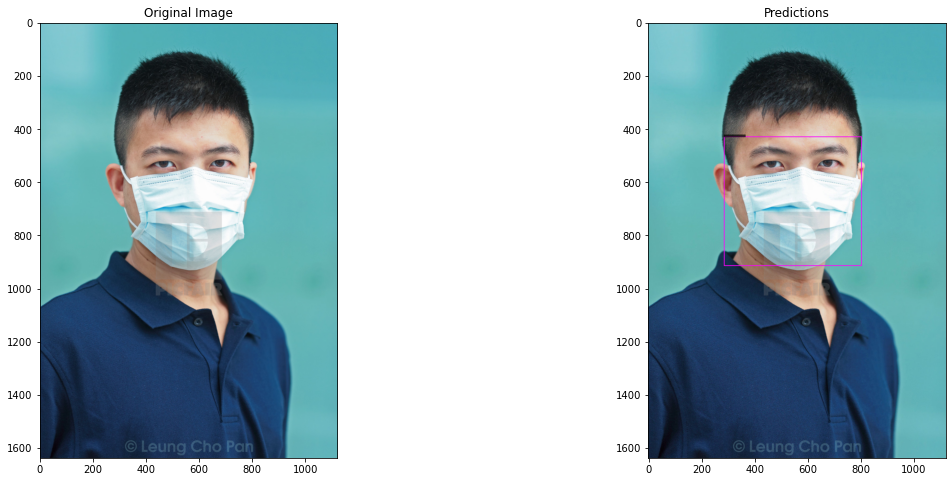

In [3]:
!./darknet/darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights ./test_images/test-image1.jpg -thresh .6 2> /dev/null
display_output("./test_images/test-image1.jpg")

### <font style="color:green">9.2. Test Image 2</font>

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 249 K-images (3 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
./test_images/test-image2.jpg: Predicted in 234.180000 milli-seconds.
Mask: 100%
Mask: 100%
Mask: 94%
No_Mask: 100%
Mask: 99%


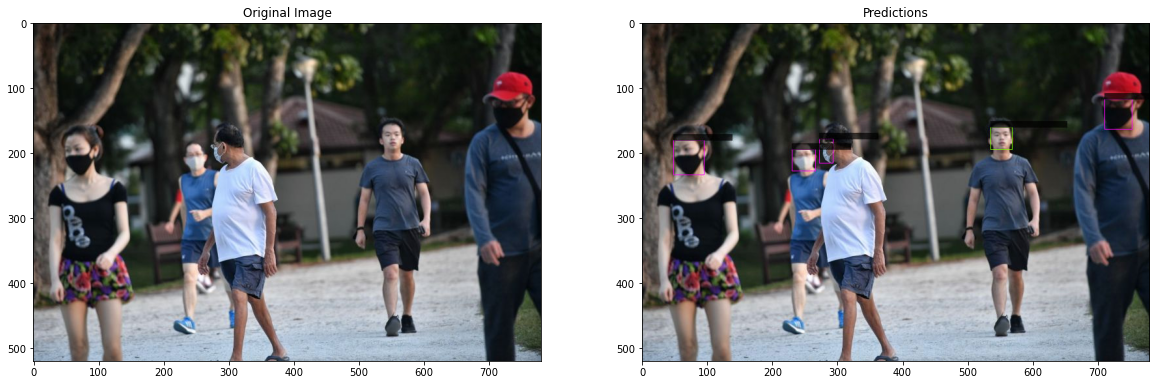

In [4]:
!./darknet/darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights ./test_images/test-image2.jpg -thresh .6 2> /dev/null
display_output("./test_images/test-image2.jpg")

### <font style="color:green">9.3. Test Image 3</font>

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 249 K-images (3 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
./test_images/test-image3.jpg: Predicted in 234.661000 milli-seconds.
Mask: 98%
Mask: 100%
Mask: 100%
No_Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 99%
Mask: 100%
Mask: 100%


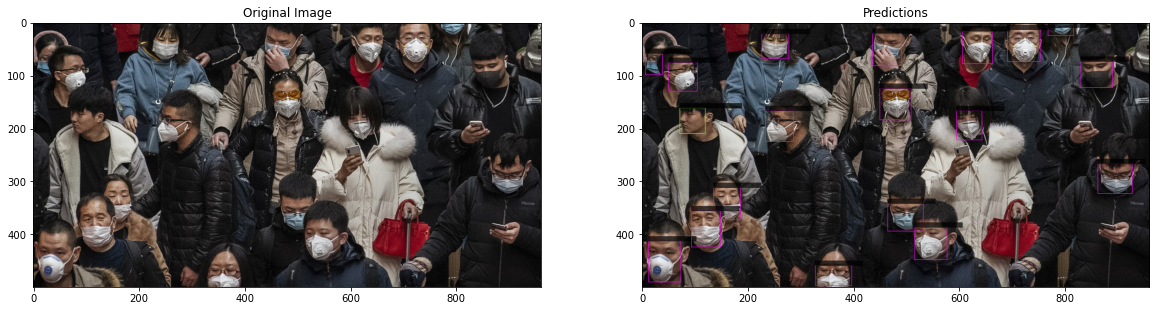

In [5]:
!./darknet/darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights ./test_images/test-image3.jpg -thresh .6 2> /dev/null
display_output("./test_images/test-image3.jpg")

### <font style="color:green">9.4. Test Image 4</font>

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 249 K-images (3 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
./test_images/test-image4.jpg: Predicted in 239.816000 milli-seconds.
No_Mask: 99%
No_Mask: 96%
Mask: 100%
Mask: 100%
No_Mask: 100%
Mask: 100%
No_Mask: 96%
Mask: 100%


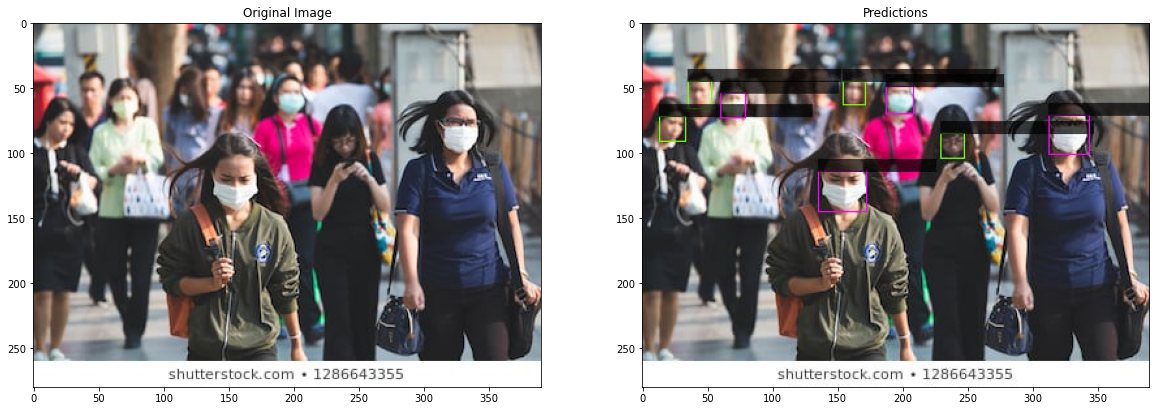

In [6]:
!./darknet/darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights ./test_images/test-image4.jpg -thresh .6 2> /dev/null
display_output("./test_images/test-image4.jpg")

### <font style="color:green">9.5. Test Video 1</font>

In [10]:
!./darknet/darknet detector demo yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights ./test_images/test-video1.mp4 -out_filename ./test-video1-labeled.mp4 -dont_show -thresh .6 2> /dev/null

Demo
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 249 K-images (3 Kilo-batches_64) 
video file: ./test_images/test-video1.mp4
Video stream: 1600 x 842 
Objects:


FPS:0.0 	 AVG_FPS:0.0
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 100% 
No_Mask: 100% 
No_Mask: 96% 
Mask: 60% 

FPS:5.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 100% 
No_Mask: 100% 
No_Mask: 96% 
Mask: 67% 

FPS:10.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 100% 
No_Mask: 100% 
No_Mask: 94% 
Mask: 75% 

FPS:15.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 100% 
No_Mask: 100% 
No_Mask: 92% 
Mask: 73% 

FPS:20.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 100% 
No_Mask: 100% 
No_Mask: 92% 
Mask: 71% 

FPS:23.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100%

Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:63.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:64.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:64.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:64.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 
Mask: 99% 

FPS:64.5 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 
Mask: 99% 

FPS:64.5 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 
Mask: 98% 

FPS:64.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:64.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:64.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 



 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:65.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:65.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:65.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:66.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:66.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:66.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:65.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:66.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:66.1 	 AVG_FPS:0.0

 cvWriteFrame 
Obj

Objects:

No_Mask: 100% 
No_Mask: 61% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 97% 

FPS:66.2 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 97% 

FPS:66.5 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 97% 

FPS:66.2 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:66.0 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 97% 

FPS:65.7 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 97% 

FPS:66.0 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 97% 

FPS:66.2 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 97% 

FPS:66.1 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 97% 

FPS:66.2 


 cvWriteFrame 
Objects:

No_Mask: 84% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 
Mask: 98% 

FPS:66.9 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:66.5 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:65.7 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:65.6 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:65.8 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 97% 

FPS:66.1 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 97% 

FPS:65.9 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:65.9 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:65.6 	 AVG_FPS:64


 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 93% 

FPS:66.5 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 94% 

FPS:66.4 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 96% 

FPS:66.4 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 96% 

FPS:66.3 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 96% 

FPS:66.5 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 97% 

FPS:66.4 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 97% 

FPS:66.6 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 97% 

FPS:66.5 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 97% 

FPS:66.5 	 AVG_FPS:64.5

 cvWriteF

Objects:

No_Mask: 74% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 85% 

FPS:65.8 	 AVG_FPS:66.2

 cvWriteFrame 
Objects:

No_Mask: 75% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 80% 

FPS:65.9 	 AVG_FPS:66.2

 cvWriteFrame 
Objects:

No_Mask: 76% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 76% 

FPS:65.8 	 AVG_FPS:66.2

 cvWriteFrame 
Objects:

No_Mask: 78% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 78% 

FPS:65.8 	 AVG_FPS:66.2

 cvWriteFrame 
Objects:

No_Mask: 75% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 84% 

FPS:66.2 	 AVG_FPS:66.2

 cvWriteFrame 
Objects:

No_Mask: 79% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 82% 

FPS:66.3 	 AVG_FPS:66.2

 cvWriteFrame 
Objects:

No_Mask: 79% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 82% 

FPS:66.2 	 AVG_FPS:66.2

 cvWriteFrame 
Objects:

No_Mask: 82% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 77% 

FPS:65.9 	 AVG_FPS:66.2

 cvWriteFrame 
Objects:

### <font style="color:green">9.6. Test Video 2</font>

In [11]:
!./darknet/darknet detector demo yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights ./test_images/test-video2.mp4 -out_filename ./test-video2-labeled.mp4 -dont_show -thresh .6 2> /dev/null

Demo
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 249 K-images (3 Kilo-batches_64) 
video file: ./test_images/test-video2.mp4
Video stream: 1280 x 718 
Objects:


FPS:0.0 	 AVG_FPS:0.0
Objects:

No_Mask: 92% 
No_Mask: 90% 
No_Mask: 84% 
No_Mask: 74% 

FPS:5.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 99% 
No_Mask: 80% 
No_Mask: 77% 

FPS:11.1 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 96% 
No_Mask: 96% 
No_Mask: 64% 

FPS:15.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 96% 
No_Mask: 96% 
No_Mask: 76% 

FPS:20.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 98% 
No_Mask: 94% 

FPS:24.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 98% 
No_Mask: 94% 

FPS:28.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 98% 
No_Mask: 95% 
No_Mask: 76% 

FPS:31.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 97% 
No_Mask: 96% 
No_Mask: 62% 

FPS:34.1 	 AVG_F


 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 96% 
No_Mask: 60% 

FPS:63.5 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 89% 
No_Mask: 87% 

FPS:63.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 98% 
No_Mask: 64% 

FPS:63.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 95% 
No_Mask: 65% 

FPS:63.4 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 95% 

FPS:63.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 85% 
No_Mask: 73% 

FPS:63.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 96% 

FPS:63.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 81% 

FPS:63.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 93% 

FPS:63.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 94% 

FPS:63.5 	 AV

Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 98% 
No_Mask: 63% 

FPS:62.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 98% 
No_Mask: 97% 
No_Mask: 85% 

FPS:63.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 99% 
No_Mask: 98% 
No_Mask: 75% 

FPS:62.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 99% 
No_Mask: 98% 
No_Mask: 73% 

FPS:62.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 98% 

FPS:62.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 97% 
No_Mask: 68% 

FPS:62.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 98% 
No_Mask: 71% 

FPS:63.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 98% 

FPS:63.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 97% 

FPS:63.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 97% 

FPS:63.8 	 AVG_FPS

Objects:

No_Mask: 100% 
No_Mask: 80% 
Mask: 78% 

FPS:64.9 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 60% 

FPS:65.1 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 

FPS:64.9 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
Mask: 67% 

FPS:65.0 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 80% 
Mask: 89% 

FPS:65.1 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
Mask: 96% 
Mask: 62% 

FPS:64.7 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 69% 
Mask: 95% 

FPS:64.7 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
Mask: 100% 
Mask: 95% 

FPS:64.4 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
Mask: 100% 
Mask: 95% 

FPS:64.6 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 81% 
Mask: 100% 
Mask: 95% 

FPS:64.5 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 95% 
Mask: 100% 
Mask: 95% 

FPS:64.5 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 83% 
Mask: 100% 
Mask: 94% 


Objects:

No_Mask: 100% 
No_Mask: 99% 
No_Mask: 93% 

FPS:64.1 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 88% 

FPS:64.0 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 98% 
No_Mask: 98% 
No_Mask: 65% 

FPS:64.1 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 97% 
No_Mask: 69% 

FPS:63.7 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 97% 
No_Mask: 70% 

FPS:63.5 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 99% 
No_Mask: 94% 
No_Mask: 66% 

FPS:63.7 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 99% 
No_Mask: 95% 

FPS:63.5 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 99% 
No_Mask: 97% 

FPS:63.5 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 96% 

FPS:63.8 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 96% 
No_Mask: 83% 
No_Mask: 78% 

FPS:63.7 	 AVG_FPS:64.4

 cvWriteFrame 
O


 cvWriteFrame 
Objects:

No_Mask: 80% 
Mask: 100% 
Mask: 94% 

FPS:64.6 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

Mask: 100% 

FPS:64.6 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 70% 
Mask: 100% 

FPS:64.5 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 74% 
Mask: 100% 

FPS:64.2 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 68% 
Mask: 100% 

FPS:64.2 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 79% 
No_Mask: 68% 
Mask: 100% 
Mask: 69% 

FPS:64.4 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 91% 
Mask: 100% 
Mask: 77% 

FPS:64.9 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 91% 
No_Mask: 91% 
No_Mask: 70% 
Mask: 100% 
Mask: 92% 

FPS:64.5 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 79% 
Mask: 100% 
Mask: 99% 
Mask: 69% 

FPS:63.4 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 90% 
Mask: 100% 
Mask: 98% 
Mask: 92% 

FPS:63.2 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 88% 
Mask: 100% 
Mask: 98% 
Mask: 94% 

FPS:63.4 	 AVG_FPS:64.4

 cvWriteFrame 


 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 96% 
No_Mask: 79% 
Mask: 98% 

FPS:64.6 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 95% 
No_Mask: 77% 
Mask: 97% 

FPS:64.6 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 62% 
Mask: 99% 
Mask: 86% 

FPS:64.5 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 98% 
Mask: 100% 

FPS:64.6 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 97% 
Mask: 100% 

FPS:64.7 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 99% 
No_Mask: 92% 
No_Mask: 80% 
No_Mask: 68% 
Mask: 100% 

FPS:64.5 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 92% 
No_Mask: 79% 
Mask: 100% 

FPS:63.7 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 93% 
No_Mask: 77% 
Mask: 100% 

FPS:63.7 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 99% 
No_Mask: 68% 
Mask: 100% 

FPS:63.6 	 AVG_FPS:64.4

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 95% 
N

Objects:

No_Mask: 100% 
No_Mask: 95% 
No_Mask: 84% 

FPS:62.0 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 95% 
No_Mask: 85% 

FPS:62.2 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 82% 
No_Mask: 60% 
Mask: 100% 
Mask: 90% 

FPS:62.5 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 98% 
No_Mask: 80% 
Mask: 100% 
Mask: 99% 

FPS:62.6 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 88% 
No_Mask: 87% 
Mask: 80% 

FPS:62.6 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 65% 
No_Mask: 62% 

FPS:62.6 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 79% 
No_Mask: 78% 

FPS:62.4 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 83% 
No_Mask: 77% 

FPS:62.1 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 87% 
No_Mask: 83% 
No_Mask: 74% 
No_Mask: 69% 

FPS:61.9 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 98% 
No_Mask: 95% 
No_Mask: 94% 
No_Mask: 93% 
No_Mask: 88% 

FPS:62.0 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:



 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 95% 
No_Mask: 88% 
No_Mask: 88% 
No_Mask: 80% 
No_Mask: 67% 
Mask: 93% 

FPS:65.4 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 94% 
No_Mask: 88% 
No_Mask: 75% 
Mask: 99% 

FPS:65.4 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 92% 
No_Mask: 72% 
No_Mask: 63% 
Mask: 100% 

FPS:65.4 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 92% 
No_Mask: 77% 
Mask: 100% 

FPS:65.1 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 95% 
No_Mask: 81% 
Mask: 100% 

FPS:65.0 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 82% 
Mask: 100% 
Mask: 94% 

FPS:65.2 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 90% 
Mask: 100% 

FPS:65.0 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 96% 
Mask: 100% 

FPS:65.3 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 93% 
No_Mask: 91% 
Mask: 100% 

FPS:65.6 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 93% 
No_Mask: 91% 
No_Mask: 79% 
Mask

Objects:

No_Mask: 100% 
No_Mask: 99% 
No_Mask: 99% 
No_Mask: 99% 
No_Mask: 97% 
No_Mask: 97% 
No_Mask: 95% 

FPS:66.1 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 99% 
No_Mask: 98% 
No_Mask: 91% 
No_Mask: 91% 
No_Mask: 86% 
No_Mask: 84% 

FPS:65.9 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 99% 
No_Mask: 98% 
No_Mask: 88% 
No_Mask: 84% 
Mask: 69% 

FPS:65.9 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 98% 
No_Mask: 90% 
No_Mask: 88% 
No_Mask: 88% 
Mask: 69% 

FPS:66.1 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 97% 
No_Mask: 92% 
No_Mask: 88% 
No_Mask: 67% 

FPS:65.8 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 99% 
No_Mask: 96% 
No_Mask: 94% 
No_Mask: 86% 
No_Mask: 66% 

FPS:65.5 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 96% 
No_Mask: 94% 
No_Mask: 86% 
No_Mask: 67% 

FPS:65.5 	 AVG_FPS:64.3

 cvWriteFrame 
Objects:

No_Mask: 100% 

Objects:

No_Mask: 95% 
No_Mask: 93% 
No_Mask: 90% 
Mask: 97% 
Mask: 60% 

FPS:64.5 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 95% 
No_Mask: 86% 
Mask: 98% 

FPS:64.9 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 95% 
No_Mask: 86% 
Mask: 98% 

FPS:64.8 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 98% 
No_Mask: 78% 
Mask: 64% 

FPS:64.9 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 93% 
No_Mask: 88% 
No_Mask: 77% 
Mask: 95% 

FPS:65.4 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 98% 
Mask: 63% 
Mask: 60% 

FPS:65.3 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 98% 
No_Mask: 97% 
No_Mask: 76% 
Mask: 87% 

FPS:65.0 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 98% 
No_Mask: 96% 

FPS:65.1 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 98% 
No_Mask: 96% 

FPS:65.1 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 99% 
No_Mask: 96% 

FPS:65.3 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_


 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 96% 
No_Mask: 79% 
No_Mask: 63% 

FPS:66.0 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 97% 
No_Mask: 97% 
No_Mask: 74% 

FPS:66.1 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 98% 
No_Mask: 67% 

FPS:66.2 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 99% 
No_Mask: 85% 

FPS:66.2 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 99% 
No_Mask: 78% 
No_Mask: 62% 

FPS:66.0 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 98% 
No_Mask: 98% 
No_Mask: 65% 
No_Mask: 62% 

FPS:66.1 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 98% 
No_Mask: 98% 
No_Mask: 67% 
No_Mask: 60% 
No_Mask: 60% 

FPS:66.2 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 98% 
No_Mask: 97% 
No_Mask: 85% 
Mask: 75% 

FPS:66.2 	 AVG_FPS:64.5

 cvWriteFrame 
Objects:

No_Mask: 96% 
No_Mask: 93% 
No_Mask: 88% 
No_Mask: 83% 
No_Mask: 74% 
Mask: 66% 

FPS:66.0 	 AVG_FPS:64.5

 cvWriteFra


 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 66% 
No_Mask: 65% 

FPS:65.6 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 99% 
No_Mask: 71% 
No_Mask: 64% 

FPS:65.4 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 80% 
No_Mask: 79% 
No_Mask: 73% 

FPS:65.4 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 87% 

FPS:65.6 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 95% 
No_Mask: 86% 
No_Mask: 64% 

FPS:65.8 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 94% 
No_Mask: 87% 

FPS:65.5 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 99% 
No_Mask: 96% 
No_Mask: 94% 

FPS:65.5 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 97% 
No_Mask: 75% 
No_Mask: 61% 

FPS:65.7 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 98% 
No_Mask: 89% 
No_Mask: 89% 

FPS

Objects:

No_Mask: 95% 
No_Mask: 88% 
No_Mask: 84% 
No_Mask: 74% 
Mask: 99% 

FPS:65.7 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 98% 
No_Mask: 91% 
Mask: 78% 

FPS:65.8 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 93% 
No_Mask: 89% 
No_Mask: 82% 
No_Mask: 64% 
No_Mask: 63% 
Mask: 68% 

FPS:65.8 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 96% 
No_Mask: 95% 
No_Mask: 85% 
No_Mask: 67% 
Mask: 78% 

FPS:65.8 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 95% 
No_Mask: 95% 
No_Mask: 89% 
No_Mask: 67% 
Mask: 79% 

FPS:65.5 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 98% 
No_Mask: 94% 
No_Mask: 90% 
No_Mask: 83% 
No_Mask: 76% 
No_Mask: 69% 

FPS:65.4 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 92% 
No_Mask: 86% 
No_Mask: 80% 
Mask: 100% 
Mask: 85% 

FPS:65.6 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 98% 
No_Mask: 97% 
No_Mask: 96% 
No_Mask: 92% 

FPS:65.6 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 97% 
No_Mask: 83% 



 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 94% 
No_Mask: 77% 
No_Mask: 72% 
Mask: 98% 
Mask: 65% 

FPS:65.7 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 88% 
No_Mask: 88% 
No_Mask: 86% 
No_Mask: 72% 
Mask: 90% 
Mask: 76% 

FPS:65.7 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 94% 
No_Mask: 75% 
No_Mask: 72% 
Mask: 100% 
Mask: 89% 

FPS:65.9 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 87% 
No_Mask: 82% 
No_Mask: 75% 
No_Mask: 68% 
Mask: 83% 
Mask: 77% 

FPS:66.2 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 95% 
No_Mask: 80% 
Mask: 92% 

FPS:66.3 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 93% 
Mask: 100% 

FPS:66.0 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 91% 
Mask: 100% 

FPS:66.1 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 89% 
Mask: 99% 

FPS:66.4 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 96% 
No_Mask: 94% 
Mask: 99% 
Mask: 65% 

FPS:66.7 	 AVG_FPS:65.6

 cvWriteFrame 
Objects:

No_Mask: 97% 
No_Mask: 95% 
Mask: 100% 

FPS:66.9 


 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 96% 
No_Mask: 83% 
No_Mask: 79% 
Mask: 100% 
Mask: 63% 

FPS:64.8 	 AVG_FPS:65.5

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 95% 
No_Mask: 84% 
No_Mask: 80% 
Mask: 100% 
Mask: 60% 

FPS:64.7 	 AVG_FPS:65.5

 cvWriteFrame 
Objects:

No_Mask: 99% 
No_Mask: 97% 
No_Mask: 95% 
No_Mask: 89% 
No_Mask: 88% 
No_Mask: 75% 
Mask: 91% 

FPS:64.4 	 AVG_FPS:65.5

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 99% 
No_Mask: 96% 
No_Mask: 91% 
No_Mask: 82% 
No_Mask: 78% 

FPS:64.6 	 AVG_FPS:65.5

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 99% 
No_Mask: 96% 
No_Mask: 86% 
No_Mask: 75% 
No_Mask: 74% 

FPS:64.5 	 AVG_FPS:65.5

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 97% 
No_Mask: 94% 
No_Mask: 88% 
No_Mask: 81% 
No_Mask: 72% 

FPS:63.5 	 AVG_FPS:65.5

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 97% 
No_Mask: 93% 
No_Mask: 67% 
No_Mask: 67% 
No_Mask: 62% 

FPS:63.3 	 AVG_FPS:65.5

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask